# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IM

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
0
Tesla V100-PCIE-32GB


## Helper functions


### Binary Accuracy


In [4]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [5]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [6]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [8]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [9]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [10]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()

    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]

            predictions = model(inputs).squeeze(1)
            label = lab.to(dev)

            # label = label.unsqueeze(1)

            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch

    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [12]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Quantum Multi-Head Attention


In [13]:
import pennylane as qml
import pennylane.templates as qmlt
import pennylane.qnn.torch as qml_qnn_torch

In [14]:
class QuantumLayer(torch.nn.Module):
    def __init__(self, n_qubits, n_qlayers=1, q_device="default.qubit"):
        super().__init__()

        dev = qml.device(q_device, wires=n_qubits, torch_device="cuda")

        @qml.qnode(dev, interface="torch")
        def qlayer(inputs, weights):
            # qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="X")
            qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
            qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RZ)
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.linear = qml_qnn_torch.TorchLayer(qlayer, weight_shapes)

    def forward(self, inputs):
        return self.linear(inputs)

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
        n_qubits=4,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(MultiHeadedAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        # The quantum layers for the query, key, and value projections
        self.k_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.q_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.v_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        # The quantum layer to combine the heads
        self.combine_heads = QuantumLayer(n_qubits, n_qlayers, q_device)

        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        assert (
            embed_dim == self.embed_dim
        ), f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(key[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(query[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(value[:, t, :]) for t in range(seq_len)]

        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x: Tensor
        x, self.attn_weights = attention(Q, K, V, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)

        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

### Quantum Feed-Forward Network


In [16]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(
        self,
        embed_dim: int,
        n_qubits: int,
        n_qlayers=1,
        dropout=0.1,
        q_device="default.qubit",
    ):
        super(FeedForward, self).__init__()
        self.ffn_dim = n_qubits

        self.linear_1 = nn.Linear(embed_dim, self.ffn_dim)
        self.linear_2 = nn.Linear(self.ffn_dim, embed_dim)
        self.vqc = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.size()
        x = self.linear_1(x)
        X = [self.vqc(x[:, t, :]) for t in range(seq_len)]
        x = torch.Tensor(pad_sequence(X))
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Quantum Encoder


In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(Encoder, self).__init__()

        self.n_qubits_transformer = n_qubits_transformer
        self.n_qubits_ffn = n_qubits_ffn
        self.n_qlayers = n_qlayers

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            mask=mask,
            n_qubits=n_qubits_transformer,
            n_qlayers=n_qlayers,
            q_device=q_device,
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(
            embed_dim, n_qubits_ffn, n_qlayers, q_device=q_device, dropout=dropout
        )

        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [18]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        max_seq_len: int,
        ffn_dim=32,
        dropout=0.1,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(TextClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        print(
            f"++ Transformer will use {n_qubits_transformer} qubits and {n_qlayers} q layers"
        )

        print(f"The feed-forward head will use {n_qubits_ffn} qubits")

        print(f"Using quantum device {q_device}")

        self.transformers = get_clones(
            Encoder(
                embed_dim,
                num_heads,
                ffn_dim,
                n_qubits_transformer=n_qubits_transformer,
                n_qubits_ffn=n_qubits_ffn,
                n_qlayers=n_qlayers,
                q_device=q_device,
            ),
            num_blocks,
        )

        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # # Normalise the data to range [0, 2*pi]
        # min_val = x.min()
        # max_val = x.max()

        # x = (x - min_val) / (max_val - min_val) * (2 * torch.pi)

        # print(f"Minimum value: {x.min()}, Maximum value: {x.max()}")

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [19]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split

save_dir = ".models"
save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
os.makedirs(save_dir, exist_ok=True)


def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=2,
    num_blocks=2,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    n_qubits_transformer=0,
    n_qubits_ffn=0,
    n_qlayers=0,
    q_device="default.qubit",
    dropout_rate=0.1,
):

    # train_iter = IMDB(root="./.datatext", split="train")
    # test_iter = IMDB(root="./.datatext", split="test")

    # train_data = to_map_style_dataset(train_iter)
    # test_data = to_map_style_dataset(test_iter)

    size = total_size

    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data = np.array(train_data)[
        np.random.choice(len(train_data), size=size, replace=False)
    ].tolist()

    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("pos: ", len([label for label, text in train_data if label == 1]))
    print("neg: ", len([label for label, text in train_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")
    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )
    test_loader = DataLoader(
        test_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        n_qubits_transformer=n_qubits_transformer,
        n_qubits_ffn=n_qubits_ffn,
        n_qlayers=n_qlayers,
        dropout=dropout_rate,
        q_device=q_device,
        max_seq_len=max_seq_len,
    )

    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )

            # scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1
                
            torch.save(
                {
                    "epoch": iepoch + 1,
                    "model_state_dict": model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    "train_loss": train_loss_list,
                    "train_acc": train_acc_list,
                    "train_auc": train_auc_list,
                    "test_loss": test_loss_list,
                    "test_acc": test_acc_list,
                    "test_auc": test_auc_list,
                },
                save_path.format(iepoch + 1),
            )

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [20]:
qml.about()

Name: PennyLane
Version: 0.37.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/nchoong/.conda/envs/quant/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane_Lightning

Platform info:           Linux-4.18.0-348.12.2.el8_5.x86_64-x86_64-with-glibc2.28
Python version:          3.11.8
Numpy version:           1.26.3
Scipy version:           1.14.0
Installed devices:
- default.clifford (PennyLane-0.37.0)
- default.gaussian (PennyLane-0.37.0)
- default.mixed (PennyLane-0.37.0)
- default.qubit (PennyLane-0.37.0)
- default.qubit.autograd (PennyLane-0.37.0)
- default.qubit.ja

In [21]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [22]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main(
    n_epochs=30,
    embed_dim=8,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=3,
    num_blocks=2,
    num_heads=2,
    q_device="default.qubit.torch",
    total_size=5000,
)

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


pos:  1999
neg:  2001


++ There will be 2 transformer blocks
++ Transformer will use 8 qubits and 3 q layers
The feed-forward head will use 8 qubits
Using quantum device default.qubit.torch
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
The model has 400,601 trainable parameters



Epoch   1/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   1/10:   1%|          | 32/4000 [00:42<1:26:49,  1.31s/batch]


Epoch   1/10:   2%|▏         | 64/4000 [01:24<1:26:16,  1.32s/batch]


Epoch   1/10:   2%|▏         | 96/4000 [02:06<1:25:55,  1.32s/batch]


Epoch   1/10:   3%|▎         | 128/4000 [02:49<1:25:43,  1.33s/batch]


Epoch   1/10:   4%|▍         | 160/4000 [03:32<1:25:32,  1.34s/batch]


Epoch   1/10:   5%|▍         | 192/4000 [04:16<1:25:12,  1.34s/batch]


Epoch   1/10:   6%|▌         | 224/4000 [04:59<1:24:49,  1.35s/batch]


Epoch   1/10:   6%|▋         | 256/4000 [05:42<1:24:13,  1.35s/batch]


Epoch   1/10:   7%|▋         | 288/4000 [06:26<1:23:52,  1.36s/batch]


Epoch   1/10:   8%|▊         | 320/4000 [07:10<1:23:17,  1.36s/batch]


Epoch   1/10:   9%|▉         | 352/4000 [07:54<1:22:54,  1.36s/batch]


Epoch   1/10:  10%|▉         | 384/4000 [08:38<1:22:18,  1.37s/batch]


Epoch   1/10:  10%|█         | 416/4000 [09:22<1:21:55,  1.37s/batch]


Epoch   1/10:  11%|█         | 448/4000 [10:06<1:21:04,  1.37s/batch]


Epoch   1/10:  12%|█▏        | 480/4000 [10:50<1:20:40,  1.38s/batch]


Epoch   1/10:  13%|█▎        | 512/4000 [11:34<1:19:54,  1.37s/batch]


Epoch   1/10:  14%|█▎        | 544/4000 [12:18<1:19:15,  1.38s/batch]


Epoch   1/10:  14%|█▍        | 576/4000 [13:02<1:18:35,  1.38s/batch]


Epoch   1/10:  15%|█▌        | 608/4000 [13:47<1:17:54,  1.38s/batch]


Epoch   1/10:  16%|█▌        | 640/4000 [14:31<1:17:24,  1.38s/batch]


Epoch   1/10:  17%|█▋        | 672/4000 [15:15<1:16:32,  1.38s/batch]


Epoch   1/10:  18%|█▊        | 704/4000 [15:59<1:15:50,  1.38s/batch]


Epoch   1/10:  18%|█▊        | 736/4000 [16:44<1:15:07,  1.38s/batch]


Epoch   1/10:  19%|█▉        | 768/4000 [17:28<1:14:22,  1.38s/batch]


Epoch   1/10:  20%|██        | 800/4000 [18:12<1:13:47,  1.38s/batch]


Epoch   1/10:  21%|██        | 832/4000 [18:56<1:13:00,  1.38s/batch]


Epoch   1/10:  22%|██▏       | 864/4000 [19:41<1:12:17,  1.38s/batch]


Epoch   1/10:  22%|██▏       | 896/4000 [20:25<1:11:35,  1.38s/batch]


Epoch   1/10:  23%|██▎       | 928/4000 [21:09<1:10:51,  1.38s/batch]


Epoch   1/10:  24%|██▍       | 960/4000 [21:53<1:10:04,  1.38s/batch]


Epoch   1/10:  25%|██▍       | 992/4000 [22:38<1:09:29,  1.39s/batch]


Epoch   1/10:  26%|██▌       | 1024/4000 [23:22<1:08:33,  1.38s/batch]


Epoch   1/10:  26%|██▋       | 1056/4000 [24:06<1:07:51,  1.38s/batch]


Epoch   1/10:  27%|██▋       | 1088/4000 [24:50<1:07:04,  1.38s/batch]


Epoch   1/10:  28%|██▊       | 1120/4000 [25:35<1:06:25,  1.38s/batch]


Epoch   1/10:  29%|██▉       | 1152/4000 [26:19<1:05:36,  1.38s/batch]


Epoch   1/10:  30%|██▉       | 1184/4000 [27:03<1:04:53,  1.38s/batch]


Epoch   1/10:  30%|███       | 1216/4000 [27:48<1:04:11,  1.38s/batch]


Epoch   1/10:  31%|███       | 1248/4000 [28:32<1:03:20,  1.38s/batch]


Epoch   1/10:  32%|███▏      | 1280/4000 [29:16<1:02:43,  1.38s/batch]


Epoch   1/10:  33%|███▎      | 1312/4000 [30:00<1:01:49,  1.38s/batch]


Epoch   1/10:  34%|███▎      | 1344/4000 [30:44<1:01:07,  1.38s/batch]


Epoch   1/10:  34%|███▍      | 1376/4000 [31:29<1:00:26,  1.38s/batch]


Epoch   1/10:  35%|███▌      | 1408/4000 [32:12<59:31,  1.38s/batch]  


Epoch   1/10:  36%|███▌      | 1440/4000 [32:57<58:52,  1.38s/batch]


Epoch   1/10:  37%|███▋      | 1472/4000 [33:41<58:12,  1.38s/batch]


Epoch   1/10:  38%|███▊      | 1504/4000 [34:25<57:19,  1.38s/batch]


Epoch   1/10:  38%|███▊      | 1536/4000 [35:09<56:40,  1.38s/batch]


Epoch   1/10:  39%|███▉      | 1568/4000 [35:53<55:58,  1.38s/batch]


Epoch   1/10:  40%|████      | 1600/4000 [36:37<55:05,  1.38s/batch]


Epoch   1/10:  41%|████      | 1632/4000 [37:21<54:26,  1.38s/batch]


Epoch   1/10:  42%|████▏     | 1664/4000 [38:06<53:43,  1.38s/batch]


Epoch   1/10:  42%|████▏     | 1696/4000 [38:50<52:59,  1.38s/batch]


Epoch   1/10:  43%|████▎     | 1728/4000 [39:34<52:20,  1.38s/batch]


Epoch   1/10:  44%|████▍     | 1760/4000 [40:18<51:28,  1.38s/batch]


Epoch   1/10:  45%|████▍     | 1792/4000 [41:02<50:47,  1.38s/batch]


Epoch   1/10:  46%|████▌     | 1824/4000 [41:46<50:03,  1.38s/batch]


Epoch   1/10:  46%|████▋     | 1856/4000 [42:30<49:14,  1.38s/batch]


Epoch   1/10:  47%|████▋     | 1888/4000 [43:15<48:36,  1.38s/batch]


Epoch   1/10:  48%|████▊     | 1920/4000 [43:59<47:52,  1.38s/batch]


Epoch   1/10:  49%|████▉     | 1952/4000 [44:43<46:58,  1.38s/batch]


Epoch   1/10:  50%|████▉     | 1984/4000 [45:27<46:12,  1.38s/batch]


Epoch   1/10:  50%|█████     | 2016/4000 [46:11<45:30,  1.38s/batch]


Epoch   1/10:  51%|█████     | 2048/4000 [46:54<44:37,  1.37s/batch]


Epoch   1/10:  52%|█████▏    | 2080/4000 [47:38<43:52,  1.37s/batch]


Epoch   1/10:  53%|█████▎    | 2112/4000 [48:22<43:14,  1.37s/batch]


Epoch   1/10:  54%|█████▎    | 2144/4000 [49:06<42:24,  1.37s/batch]


Epoch   1/10:  54%|█████▍    | 2176/4000 [49:50<41:40,  1.37s/batch]


Epoch   1/10:  55%|█████▌    | 2208/4000 [50:34<40:56,  1.37s/batch]


Epoch   1/10:  56%|█████▌    | 2240/4000 [51:17<40:10,  1.37s/batch]


Epoch   1/10:  57%|█████▋    | 2272/4000 [52:01<39:27,  1.37s/batch]


Epoch   1/10:  58%|█████▊    | 2304/4000 [52:45<38:46,  1.37s/batch]


Epoch   1/10:  58%|█████▊    | 2336/4000 [53:29<37:54,  1.37s/batch]


Epoch   1/10:  59%|█████▉    | 2368/4000 [54:13<37:12,  1.37s/batch]


Epoch   1/10:  60%|██████    | 2400/4000 [54:56<36:30,  1.37s/batch]


Epoch   1/10:  61%|██████    | 2432/4000 [55:40<35:40,  1.36s/batch]


Epoch   1/10:  62%|██████▏   | 2464/4000 [56:24<34:59,  1.37s/batch]


Epoch   1/10:  62%|██████▏   | 2496/4000 [57:08<34:16,  1.37s/batch]


Epoch   1/10:  63%|██████▎   | 2528/4000 [57:51<33:30,  1.37s/batch]


Epoch   1/10:  64%|██████▍   | 2560/4000 [58:35<32:52,  1.37s/batch]


Epoch   1/10:  65%|██████▍   | 2592/4000 [59:19<32:06,  1.37s/batch]


Epoch   1/10:  66%|██████▌   | 2624/4000 [1:00:03<31:23,  1.37s/batch]


Epoch   1/10:  66%|██████▋   | 2656/4000 [1:00:47<30:41,  1.37s/batch]


Epoch   1/10:  67%|██████▋   | 2688/4000 [1:01:30<29:55,  1.37s/batch]


Epoch   1/10:  68%|██████▊   | 2720/4000 [1:02:14<29:11,  1.37s/batch]


Epoch   1/10:  69%|██████▉   | 2752/4000 [1:02:58<28:24,  1.37s/batch]


Epoch   1/10:  70%|██████▉   | 2784/4000 [1:03:42<27:42,  1.37s/batch]


Epoch   1/10:  70%|███████   | 2816/4000 [1:04:25<26:58,  1.37s/batch]


Epoch   1/10:  71%|███████   | 2848/4000 [1:05:09<26:14,  1.37s/batch]


Epoch   1/10:  72%|███████▏  | 2880/4000 [1:05:53<25:32,  1.37s/batch]


Epoch   1/10:  73%|███████▎  | 2912/4000 [1:06:37<24:50,  1.37s/batch]


Epoch   1/10:  74%|███████▎  | 2944/4000 [1:07:21<24:05,  1.37s/batch]


Epoch   1/10:  74%|███████▍  | 2976/4000 [1:08:05<23:22,  1.37s/batch]


Epoch   1/10:  75%|███████▌  | 3008/4000 [1:08:49<22:41,  1.37s/batch]


Epoch   1/10:  76%|███████▌  | 3040/4000 [1:09:32<21:56,  1.37s/batch]


Epoch   1/10:  77%|███████▋  | 3072/4000 [1:10:16<21:13,  1.37s/batch]


Epoch   1/10:  78%|███████▊  | 3104/4000 [1:11:00<20:30,  1.37s/batch]


Epoch   1/10:  78%|███████▊  | 3136/4000 [1:11:44<19:45,  1.37s/batch]


Epoch   1/10:  79%|███████▉  | 3168/4000 [1:12:28<19:02,  1.37s/batch]


Epoch   1/10:  80%|████████  | 3200/4000 [1:13:12<18:18,  1.37s/batch]


Epoch   1/10:  81%|████████  | 3232/4000 [1:13:56<17:33,  1.37s/batch]


Epoch   1/10:  82%|████████▏ | 3264/4000 [1:14:40<16:50,  1.37s/batch]


Epoch   1/10:  82%|████████▏ | 3296/4000 [1:15:24<16:05,  1.37s/batch]


Epoch   1/10:  83%|████████▎ | 3328/4000 [1:16:08<15:20,  1.37s/batch]


Epoch   1/10:  84%|████████▍ | 3360/4000 [1:16:51<14:37,  1.37s/batch]


Epoch   1/10:  85%|████████▍ | 3392/4000 [1:17:36<13:55,  1.37s/batch]


Epoch   1/10:  86%|████████▌ | 3424/4000 [1:18:19<13:10,  1.37s/batch]


Epoch   1/10:  86%|████████▋ | 3456/4000 [1:19:03<12:26,  1.37s/batch]


Epoch   1/10:  87%|████████▋ | 3488/4000 [1:19:48<11:43,  1.37s/batch]


Epoch   1/10:  88%|████████▊ | 3520/4000 [1:20:31<10:57,  1.37s/batch]


Epoch   1/10:  89%|████████▉ | 3552/4000 [1:21:15<10:14,  1.37s/batch]


Epoch   1/10:  90%|████████▉ | 3584/4000 [1:21:59<09:30,  1.37s/batch]


Epoch   1/10:  90%|█████████ | 3616/4000 [1:22:43<08:46,  1.37s/batch]


Epoch   1/10:  91%|█████████ | 3648/4000 [1:23:27<08:02,  1.37s/batch]


Epoch   1/10:  92%|█████████▏| 3680/4000 [1:24:11<07:20,  1.38s/batch]


Epoch   1/10:  93%|█████████▎| 3712/4000 [1:24:55<06:34,  1.37s/batch]


Epoch   1/10:  94%|█████████▎| 3744/4000 [1:25:39<05:51,  1.37s/batch]


Epoch   1/10:  94%|█████████▍| 3776/4000 [1:26:23<05:07,  1.37s/batch]


Epoch   1/10:  95%|█████████▌| 3808/4000 [1:27:06<04:22,  1.37s/batch]


Epoch   1/10:  96%|█████████▌| 3840/4000 [1:27:50<03:38,  1.37s/batch]


Epoch   1/10:  97%|█████████▋| 3872/4000 [1:28:34<02:55,  1.37s/batch]


Epoch   1/10:  98%|█████████▊| 3904/4000 [1:29:18<02:11,  1.37s/batch]


Epoch   1/10:  98%|█████████▊| 3936/4000 [1:30:01<01:27,  1.37s/batch]


Epoch   1/10:  99%|█████████▉| 3968/4000 [1:30:45<00:43,  1.37s/batch]


Epoch   1/10: 100%|██████████| 4000/4000 [1:31:29<00:00,  1.37s/batch]


Epoch   1/10: 100%|██████████| 4000/4000 [1:38:29<00:00,  1.37s/batch, Epoch = 98m 29s, Loss = 0.7053|0.7024, Acc = 0.496|0.494, AUC = 49.064|48.804]


Epoch   1/10: 100%|██████████| 4000/4000 [1:38:29<00:00,  1.48s/batch, Epoch = 98m 29s, Loss = 0.7053|0.7024, Acc = 0.496|0.494, AUC = 49.064|48.804]


Epoch   2/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   2/10:   1%|          | 32/4000 [00:39<1:21:53,  1.24s/batch]


Epoch   2/10:   2%|▏         | 64/4000 [01:20<1:23:13,  1.27s/batch]


Epoch   2/10:   2%|▏         | 96/4000 [02:02<1:23:02,  1.28s/batch]


Epoch   2/10:   3%|▎         | 128/4000 [02:44<1:23:18,  1.29s/batch]


Epoch   2/10:   4%|▍         | 160/4000 [03:26<1:23:23,  1.30s/batch]


Epoch   2/10:   5%|▍         | 192/4000 [04:08<1:23:14,  1.31s/batch]


Epoch   2/10:   6%|▌         | 224/4000 [04:51<1:22:56,  1.32s/batch]


Epoch   2/10:   6%|▋         | 256/4000 [05:34<1:22:51,  1.33s/batch]


Epoch   2/10:   7%|▋         | 288/4000 [06:17<1:22:23,  1.33s/batch]


Epoch   2/10:   8%|▊         | 320/4000 [07:00<1:21:56,  1.34s/batch]


Epoch   2/10:   9%|▉         | 352/4000 [07:44<1:21:46,  1.35s/batch]


Epoch   2/10:  10%|▉         | 384/4000 [08:27<1:21:11,  1.35s/batch]


Epoch   2/10:  10%|█         | 416/4000 [09:11<1:20:41,  1.35s/batch]


Epoch   2/10:  11%|█         | 448/4000 [09:54<1:20:09,  1.35s/batch]


Epoch   2/10:  12%|█▏        | 480/4000 [10:38<1:19:28,  1.35s/batch]


Epoch   2/10:  13%|█▎        | 512/4000 [11:21<1:18:49,  1.36s/batch]


Epoch   2/10:  14%|█▎        | 544/4000 [12:05<1:18:16,  1.36s/batch]


Epoch   2/10:  14%|█▍        | 576/4000 [12:48<1:17:31,  1.36s/batch]


Epoch   2/10:  15%|█▌        | 608/4000 [13:32<1:16:48,  1.36s/batch]


Epoch   2/10:  16%|█▌        | 640/4000 [14:15<1:16:15,  1.36s/batch]


Epoch   2/10:  17%|█▋        | 672/4000 [14:59<1:15:25,  1.36s/batch]


Epoch   2/10:  18%|█▊        | 704/4000 [15:43<1:14:47,  1.36s/batch]


Epoch   2/10:  18%|█▊        | 736/4000 [16:26<1:14:10,  1.36s/batch]


Epoch   2/10:  19%|█▉        | 768/4000 [17:10<1:13:22,  1.36s/batch]


Epoch   2/10:  20%|██        | 800/4000 [17:54<1:12:45,  1.36s/batch]


Epoch   2/10:  21%|██        | 832/4000 [18:37<1:12:04,  1.37s/batch]


Epoch   2/10:  22%|██▏       | 864/4000 [19:21<1:11:19,  1.36s/batch]


Epoch   2/10:  22%|██▏       | 896/4000 [20:05<1:10:38,  1.37s/batch]


Epoch   2/10:  23%|██▎       | 928/4000 [20:49<1:09:56,  1.37s/batch]


Epoch   2/10:  24%|██▍       | 960/4000 [21:32<1:09:15,  1.37s/batch]


Epoch   2/10:  25%|██▍       | 992/4000 [22:16<1:08:35,  1.37s/batch]


Epoch   2/10:  26%|██▌       | 1024/4000 [23:00<1:07:40,  1.36s/batch]


Epoch   2/10:  26%|██▋       | 1056/4000 [23:43<1:06:52,  1.36s/batch]


Epoch   2/10:  27%|██▋       | 1088/4000 [24:27<1:06:15,  1.37s/batch]


Epoch   2/10:  28%|██▊       | 1120/4000 [25:10<1:05:26,  1.36s/batch]


Epoch   2/10:  29%|██▉       | 1152/4000 [25:54<1:04:41,  1.36s/batch]


Epoch   2/10:  30%|██▉       | 1184/4000 [26:38<1:03:58,  1.36s/batch]


Epoch   2/10:  30%|███       | 1216/4000 [27:21<1:03:16,  1.36s/batch]


Epoch   2/10:  31%|███       | 1248/4000 [28:05<1:02:33,  1.36s/batch]


Epoch   2/10:  32%|███▏      | 1280/4000 [28:48<1:01:45,  1.36s/batch]


Epoch   2/10:  33%|███▎      | 1312/4000 [29:32<1:01:00,  1.36s/batch]


Epoch   2/10:  34%|███▎      | 1344/4000 [30:16<1:00:24,  1.36s/batch]


Epoch   2/10:  34%|███▍      | 1376/4000 [30:59<59:31,  1.36s/batch]  


Epoch   2/10:  35%|███▌      | 1408/4000 [31:43<58:49,  1.36s/batch]


Epoch   2/10:  36%|███▌      | 1440/4000 [32:26<58:08,  1.36s/batch]


Epoch   2/10:  37%|███▋      | 1472/4000 [33:10<57:21,  1.36s/batch]


Epoch   2/10:  38%|███▊      | 1504/4000 [33:54<56:39,  1.36s/batch]


Epoch   2/10:  38%|███▊      | 1536/4000 [34:37<55:58,  1.36s/batch]


Epoch   2/10:  39%|███▉      | 1568/4000 [35:21<55:15,  1.36s/batch]


Epoch   2/10:  40%|████      | 1600/4000 [36:04<54:28,  1.36s/batch]


Epoch   2/10:  41%|████      | 1632/4000 [36:48<53:47,  1.36s/batch]


Epoch   2/10:  42%|████▏     | 1664/4000 [37:32<53:09,  1.37s/batch]


Epoch   2/10:  42%|████▏     | 1696/4000 [38:15<52:19,  1.36s/batch]


Epoch   2/10:  43%|████▎     | 1728/4000 [38:59<51:39,  1.36s/batch]


Epoch   2/10:  44%|████▍     | 1760/4000 [39:43<50:54,  1.36s/batch]


Epoch   2/10:  45%|████▍     | 1792/4000 [40:26<50:03,  1.36s/batch]


Epoch   2/10:  46%|████▌     | 1824/4000 [41:10<49:22,  1.36s/batch]


Epoch   2/10:  46%|████▋     | 1856/4000 [41:53<48:39,  1.36s/batch]


Epoch   2/10:  47%|████▋     | 1888/4000 [42:37<47:55,  1.36s/batch]


Epoch   2/10:  48%|████▊     | 1920/4000 [43:20<47:09,  1.36s/batch]


Epoch   2/10:  49%|████▉     | 1952/4000 [44:04<46:25,  1.36s/batch]


Epoch   2/10:  50%|████▉     | 1984/4000 [44:47<45:39,  1.36s/batch]


Epoch   2/10:  50%|█████     | 2016/4000 [45:31<44:56,  1.36s/batch]


Epoch   2/10:  51%|█████     | 2048/4000 [46:14<44:13,  1.36s/batch]


Epoch   2/10:  52%|█████▏    | 2080/4000 [46:58<43:28,  1.36s/batch]


Epoch   2/10:  53%|█████▎    | 2112/4000 [47:41<42:43,  1.36s/batch]


Epoch   2/10:  54%|█████▎    | 2144/4000 [48:24<41:59,  1.36s/batch]


Epoch   2/10:  54%|█████▍    | 2176/4000 [49:08<41:17,  1.36s/batch]


Epoch   2/10:  55%|█████▌    | 2208/4000 [49:51<40:33,  1.36s/batch]


Epoch   2/10:  56%|█████▌    | 2240/4000 [50:35<39:53,  1.36s/batch]


Epoch   2/10:  57%|█████▋    | 2272/4000 [51:18<39:08,  1.36s/batch]


Epoch   2/10:  58%|█████▊    | 2304/4000 [52:02<38:24,  1.36s/batch]


Epoch   2/10:  58%|█████▊    | 2336/4000 [52:45<37:41,  1.36s/batch]


Epoch   2/10:  59%|█████▉    | 2368/4000 [53:29<36:56,  1.36s/batch]


Epoch   2/10:  60%|██████    | 2400/4000 [54:12<36:12,  1.36s/batch]


Epoch   2/10:  61%|██████    | 2432/4000 [54:56<35:30,  1.36s/batch]


Epoch   2/10:  62%|██████▏   | 2464/4000 [55:39<34:46,  1.36s/batch]


Epoch   2/10:  62%|██████▏   | 2496/4000 [56:23<34:04,  1.36s/batch]


Epoch   2/10:  63%|██████▎   | 2528/4000 [57:06<33:21,  1.36s/batch]


Epoch   2/10:  64%|██████▍   | 2560/4000 [57:50<32:37,  1.36s/batch]


Epoch   2/10:  65%|██████▍   | 2592/4000 [58:33<31:51,  1.36s/batch]


Epoch   2/10:  66%|██████▌   | 2624/4000 [59:17<31:07,  1.36s/batch]


Epoch   2/10:  66%|██████▋   | 2656/4000 [1:00:00<30:21,  1.36s/batch]


Epoch   2/10:  67%|██████▋   | 2688/4000 [1:00:43<29:39,  1.36s/batch]


Epoch   2/10:  68%|██████▊   | 2720/4000 [1:01:27<28:54,  1.36s/batch]


Epoch   2/10:  69%|██████▉   | 2752/4000 [1:02:10<28:10,  1.35s/batch]


Epoch   2/10:  70%|██████▉   | 2784/4000 [1:02:53<27:24,  1.35s/batch]


Epoch   2/10:  70%|███████   | 2816/4000 [1:03:36<26:42,  1.35s/batch]


Epoch   2/10:  71%|███████   | 2848/4000 [1:04:20<26:01,  1.36s/batch]


Epoch   2/10:  72%|███████▏  | 2880/4000 [1:05:03<25:16,  1.35s/batch]


Epoch   2/10:  73%|███████▎  | 2912/4000 [1:05:46<24:31,  1.35s/batch]


Epoch   2/10:  74%|███████▎  | 2944/4000 [1:06:29<23:46,  1.35s/batch]


Epoch   2/10:  74%|███████▍  | 2976/4000 [1:07:13<23:04,  1.35s/batch]


Epoch   2/10:  75%|███████▌  | 3008/4000 [1:07:56<22:22,  1.35s/batch]


Epoch   2/10:  76%|███████▌  | 3040/4000 [1:08:40<21:40,  1.35s/batch]


Epoch   2/10:  77%|███████▋  | 3072/4000 [1:09:23<20:54,  1.35s/batch]


Epoch   2/10:  78%|███████▊  | 3104/4000 [1:10:06<20:11,  1.35s/batch]


Epoch   2/10:  78%|███████▊  | 3136/4000 [1:10:49<19:25,  1.35s/batch]


Epoch   2/10:  79%|███████▉  | 3168/4000 [1:11:32<18:42,  1.35s/batch]


Epoch   2/10:  80%|████████  | 3200/4000 [1:12:15<17:59,  1.35s/batch]


Epoch   2/10:  81%|████████  | 3232/4000 [1:12:59<17:17,  1.35s/batch]


Epoch   2/10:  82%|████████▏ | 3264/4000 [1:13:42<16:33,  1.35s/batch]


Epoch   2/10:  82%|████████▏ | 3296/4000 [1:14:25<15:49,  1.35s/batch]


Epoch   2/10:  83%|████████▎ | 3328/4000 [1:15:08<15:06,  1.35s/batch]


Epoch   2/10:  84%|████████▍ | 3360/4000 [1:15:51<14:22,  1.35s/batch]


Epoch   2/10:  85%|████████▍ | 3392/4000 [1:16:34<13:39,  1.35s/batch]


Epoch   2/10:  86%|████████▌ | 3424/4000 [1:17:17<12:56,  1.35s/batch]


Epoch   2/10:  86%|████████▋ | 3456/4000 [1:18:01<12:13,  1.35s/batch]


Epoch   2/10:  87%|████████▋ | 3488/4000 [1:18:44<11:31,  1.35s/batch]


Epoch   2/10:  88%|████████▊ | 3520/4000 [1:19:27<10:47,  1.35s/batch]


Epoch   2/10:  89%|████████▉ | 3552/4000 [1:20:10<10:02,  1.35s/batch]


Epoch   2/10:  90%|████████▉ | 3584/4000 [1:20:53<09:19,  1.35s/batch]


Epoch   2/10:  90%|█████████ | 3616/4000 [1:21:36<08:36,  1.34s/batch]


Epoch   2/10:  91%|█████████ | 3648/4000 [1:22:19<07:53,  1.35s/batch]


Epoch   2/10:  92%|█████████▏| 3680/4000 [1:23:02<07:10,  1.35s/batch]


Epoch   2/10:  93%|█████████▎| 3712/4000 [1:23:45<06:27,  1.34s/batch]


Epoch   2/10:  94%|█████████▎| 3744/4000 [1:24:28<05:44,  1.34s/batch]


Epoch   2/10:  94%|█████████▍| 3776/4000 [1:25:11<05:01,  1.35s/batch]


Epoch   2/10:  95%|█████████▌| 3808/4000 [1:25:54<04:18,  1.35s/batch]


Epoch   2/10:  96%|█████████▌| 3840/4000 [1:26:37<03:35,  1.35s/batch]


Epoch   2/10:  97%|█████████▋| 3872/4000 [1:27:20<02:52,  1.35s/batch]


Epoch   2/10:  98%|█████████▊| 3904/4000 [1:28:03<02:09,  1.34s/batch]


Epoch   2/10:  98%|█████████▊| 3936/4000 [1:28:46<01:26,  1.35s/batch]


Epoch   2/10:  99%|█████████▉| 3968/4000 [1:29:29<00:43,  1.34s/batch]


Epoch   2/10: 100%|██████████| 4000/4000 [1:30:13<00:00,  1.35s/batch]


Epoch   2/10: 100%|██████████| 4000/4000 [1:37:06<00:00,  1.35s/batch, Epoch = 97m 6s, Loss = 0.7005|0.6985, Acc = 0.482|0.507, AUC = 48.030|48.812]


Epoch   2/10: 100%|██████████| 4000/4000 [1:37:06<00:00,  1.46s/batch, Epoch = 97m 6s, Loss = 0.7005|0.6985, Acc = 0.482|0.507, AUC = 48.030|48.812]


Epoch   3/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   3/10:   1%|          | 32/4000 [00:39<1:20:44,  1.22s/batch]


Epoch   3/10:   2%|▏         | 64/4000 [01:19<1:21:52,  1.25s/batch]


Epoch   3/10:   2%|▏         | 96/4000 [02:00<1:22:13,  1.26s/batch]


Epoch   3/10:   3%|▎         | 128/4000 [02:41<1:22:12,  1.27s/batch]


Epoch   3/10:   4%|▍         | 160/4000 [03:23<1:22:08,  1.28s/batch]


Epoch   3/10:   5%|▍         | 192/4000 [04:05<1:22:06,  1.29s/batch]


Epoch   3/10:   6%|▌         | 224/4000 [04:47<1:22:00,  1.30s/batch]


Epoch   3/10:   6%|▋         | 256/4000 [05:30<1:21:52,  1.31s/batch]


Epoch   3/10:   7%|▋         | 288/4000 [06:12<1:21:28,  1.32s/batch]


Epoch   3/10:   8%|▊         | 320/4000 [06:55<1:21:15,  1.32s/batch]


Epoch   3/10:   9%|▉         | 352/4000 [07:38<1:20:50,  1.33s/batch]


Epoch   3/10:  10%|▉         | 384/4000 [08:21<1:20:25,  1.33s/batch]


Epoch   3/10:  10%|█         | 416/4000 [09:04<1:19:55,  1.34s/batch]


Epoch   3/10:  11%|█         | 448/4000 [09:48<1:19:20,  1.34s/batch]


Epoch   3/10:  12%|█▏        | 480/4000 [10:31<1:18:42,  1.34s/batch]


Epoch   3/10:  13%|█▎        | 512/4000 [11:14<1:18:10,  1.34s/batch]


Epoch   3/10:  14%|█▎        | 544/4000 [11:57<1:17:32,  1.35s/batch]


Epoch   3/10:  14%|█▍        | 576/4000 [12:40<1:16:44,  1.34s/batch]


Epoch   3/10:  15%|█▌        | 608/4000 [13:23<1:16:06,  1.35s/batch]


Epoch   3/10:  16%|█▌        | 640/4000 [14:06<1:15:29,  1.35s/batch]


Epoch   3/10:  17%|█▋        | 672/4000 [14:50<1:14:45,  1.35s/batch]


Epoch   3/10:  18%|█▊        | 704/4000 [15:33<1:14:06,  1.35s/batch]


Epoch   3/10:  18%|█▊        | 736/4000 [16:16<1:13:20,  1.35s/batch]


Epoch   3/10:  19%|█▉        | 768/4000 [16:59<1:12:32,  1.35s/batch]


Epoch   3/10:  20%|██        | 800/4000 [17:42<1:11:48,  1.35s/batch]


Epoch   3/10:  21%|██        | 832/4000 [18:25<1:11:04,  1.35s/batch]


Epoch   3/10:  22%|██▏       | 864/4000 [19:08<1:10:15,  1.34s/batch]


Epoch   3/10:  22%|██▏       | 896/4000 [19:51<1:09:35,  1.35s/batch]


Epoch   3/10:  23%|██▎       | 928/4000 [20:34<1:08:53,  1.35s/batch]


Epoch   3/10:  24%|██▍       | 960/4000 [21:17<1:08:05,  1.34s/batch]


Epoch   3/10:  25%|██▍       | 992/4000 [22:00<1:07:26,  1.35s/batch]


Epoch   3/10:  26%|██▌       | 1024/4000 [22:43<1:06:44,  1.35s/batch]


Epoch   3/10:  26%|██▋       | 1056/4000 [23:26<1:06:01,  1.35s/batch]


Epoch   3/10:  27%|██▋       | 1088/4000 [24:09<1:05:18,  1.35s/batch]


Epoch   3/10:  28%|██▊       | 1120/4000 [24:52<1:04:35,  1.35s/batch]


Epoch   3/10:  29%|██▉       | 1152/4000 [25:35<1:03:50,  1.34s/batch]


Epoch   3/10:  30%|██▉       | 1184/4000 [26:18<1:03:08,  1.35s/batch]


Epoch   3/10:  30%|███       | 1216/4000 [27:01<1:02:23,  1.34s/batch]


Epoch   3/10:  31%|███       | 1248/4000 [27:44<1:01:41,  1.35s/batch]


Epoch   3/10:  32%|███▏      | 1280/4000 [28:28<1:01:06,  1.35s/batch]


Epoch   3/10:  33%|███▎      | 1312/4000 [29:11<1:00:28,  1.35s/batch]


Epoch   3/10:  34%|███▎      | 1344/4000 [29:54<59:39,  1.35s/batch]  


Epoch   3/10:  34%|███▍      | 1376/4000 [30:37<58:58,  1.35s/batch]


Epoch   3/10:  35%|███▌      | 1408/4000 [31:20<58:15,  1.35s/batch]


Epoch   3/10:  36%|███▌      | 1440/4000 [32:03<57:26,  1.35s/batch]


Epoch   3/10:  37%|███▋      | 1472/4000 [32:47<56:44,  1.35s/batch]


Epoch   3/10:  38%|███▊      | 1504/4000 [33:30<56:06,  1.35s/batch]


Epoch   3/10:  38%|███▊      | 1536/4000 [34:13<55:21,  1.35s/batch]


Epoch   3/10:  39%|███▉      | 1568/4000 [34:56<54:35,  1.35s/batch]


Epoch   3/10:  40%|████      | 1600/4000 [35:39<53:50,  1.35s/batch]


Epoch   3/10:  41%|████      | 1632/4000 [36:22<53:03,  1.34s/batch]


Epoch   3/10:  42%|████▏     | 1664/4000 [37:05<52:23,  1.35s/batch]


Epoch   3/10:  42%|████▏     | 1696/4000 [37:48<51:40,  1.35s/batch]


Epoch   3/10:  43%|████▎     | 1728/4000 [38:31<50:54,  1.34s/batch]


Epoch   3/10:  44%|████▍     | 1760/4000 [39:14<50:10,  1.34s/batch]


Epoch   3/10:  45%|████▍     | 1792/4000 [39:57<49:29,  1.35s/batch]


Epoch   3/10:  46%|████▌     | 1824/4000 [40:40<48:50,  1.35s/batch]


Epoch   3/10:  46%|████▋     | 1856/4000 [41:23<48:06,  1.35s/batch]


Epoch   3/10:  47%|████▋     | 1888/4000 [42:06<47:18,  1.34s/batch]


Epoch   3/10:  48%|████▊     | 1920/4000 [42:49<46:35,  1.34s/batch]


Epoch   3/10:  49%|████▉     | 1952/4000 [43:32<45:54,  1.35s/batch]


Epoch   3/10:  50%|████▉     | 1984/4000 [44:16<45:17,  1.35s/batch]


Epoch   3/10:  50%|█████     | 2016/4000 [44:59<44:31,  1.35s/batch]


Epoch   3/10:  51%|█████     | 2048/4000 [45:41<43:43,  1.34s/batch]


Epoch   3/10:  52%|█████▏    | 2080/4000 [46:24<43:00,  1.34s/batch]


Epoch   3/10:  53%|█████▎    | 2112/4000 [47:07<42:15,  1.34s/batch]


Epoch   3/10:  54%|█████▎    | 2144/4000 [47:51<41:38,  1.35s/batch]


Epoch   3/10:  54%|█████▍    | 2176/4000 [48:34<40:57,  1.35s/batch]


Epoch   3/10:  55%|█████▌    | 2208/4000 [49:17<40:18,  1.35s/batch]


Epoch   3/10:  56%|█████▌    | 2240/4000 [50:00<39:34,  1.35s/batch]


Epoch   3/10:  57%|█████▋    | 2272/4000 [50:44<38:51,  1.35s/batch]


Epoch   3/10:  58%|█████▊    | 2304/4000 [51:27<38:10,  1.35s/batch]


Epoch   3/10:  58%|█████▊    | 2336/4000 [52:10<37:25,  1.35s/batch]


Epoch   3/10:  59%|█████▉    | 2368/4000 [52:53<36:45,  1.35s/batch]


Epoch   3/10:  60%|██████    | 2400/4000 [53:36<35:58,  1.35s/batch]


Epoch   3/10:  61%|██████    | 2432/4000 [54:19<35:07,  1.34s/batch]


Epoch   3/10:  62%|██████▏   | 2464/4000 [55:02<34:24,  1.34s/batch]


Epoch   3/10:  62%|██████▏   | 2496/4000 [55:45<33:43,  1.35s/batch]


Epoch   3/10:  63%|██████▎   | 2528/4000 [56:28<33:02,  1.35s/batch]


Epoch   3/10:  64%|██████▍   | 2560/4000 [57:11<32:19,  1.35s/batch]


Epoch   3/10:  65%|██████▍   | 2592/4000 [57:55<31:37,  1.35s/batch]


Epoch   3/10:  66%|██████▌   | 2624/4000 [58:38<30:51,  1.35s/batch]


Epoch   3/10:  66%|██████▋   | 2656/4000 [59:20<30:06,  1.34s/batch]


Epoch   3/10:  67%|██████▋   | 2688/4000 [1:00:04<29:24,  1.34s/batch]


Epoch   3/10:  68%|██████▊   | 2720/4000 [1:00:46<28:36,  1.34s/batch]


Epoch   3/10:  69%|██████▉   | 2752/4000 [1:01:29<27:53,  1.34s/batch]


Epoch   3/10:  70%|██████▉   | 2784/4000 [1:02:12<27:07,  1.34s/batch]


Epoch   3/10:  70%|███████   | 2816/4000 [1:02:54<26:23,  1.34s/batch]


Epoch   3/10:  71%|███████   | 2848/4000 [1:03:37<25:39,  1.34s/batch]


Epoch   3/10:  72%|███████▏  | 2880/4000 [1:04:20<24:57,  1.34s/batch]


Epoch   3/10:  73%|███████▎  | 2912/4000 [1:05:03<24:13,  1.34s/batch]


Epoch   3/10:  74%|███████▎  | 2944/4000 [1:05:45<23:28,  1.33s/batch]


Epoch   3/10:  74%|███████▍  | 2976/4000 [1:06:28<22:45,  1.33s/batch]


Epoch   3/10:  75%|███████▌  | 3008/4000 [1:07:10<22:02,  1.33s/batch]


Epoch   3/10:  76%|███████▌  | 3040/4000 [1:07:53<21:20,  1.33s/batch]


Epoch   3/10:  77%|███████▋  | 3072/4000 [1:08:36<20:38,  1.33s/batch]


Epoch   3/10:  78%|███████▊  | 3104/4000 [1:09:19<19:55,  1.33s/batch]


Epoch   3/10:  78%|███████▊  | 3136/4000 [1:10:01<19:12,  1.33s/batch]


Epoch   3/10:  79%|███████▉  | 3168/4000 [1:10:44<18:29,  1.33s/batch]


Epoch   3/10:  80%|████████  | 3200/4000 [1:11:26<17:45,  1.33s/batch]


Epoch   3/10:  81%|████████  | 3232/4000 [1:12:09<17:03,  1.33s/batch]


Epoch   3/10:  82%|████████▏ | 3264/4000 [1:12:52<16:20,  1.33s/batch]


Epoch   3/10:  82%|████████▏ | 3296/4000 [1:13:34<15:37,  1.33s/batch]


Epoch   3/10:  83%|████████▎ | 3328/4000 [1:14:17<14:55,  1.33s/batch]


Epoch   3/10:  84%|████████▍ | 3360/4000 [1:15:00<14:13,  1.33s/batch]


Epoch   3/10:  85%|████████▍ | 3392/4000 [1:15:42<13:30,  1.33s/batch]


Epoch   3/10:  86%|████████▌ | 3424/4000 [1:16:25<12:47,  1.33s/batch]


Epoch   3/10:  86%|████████▋ | 3456/4000 [1:17:08<12:04,  1.33s/batch]


Epoch   3/10:  87%|████████▋ | 3488/4000 [1:17:50<11:22,  1.33s/batch]


Epoch   3/10:  88%|████████▊ | 3520/4000 [1:18:33<10:39,  1.33s/batch]


Epoch   3/10:  89%|████████▉ | 3552/4000 [1:19:16<09:56,  1.33s/batch]


Epoch   3/10:  90%|████████▉ | 3584/4000 [1:19:58<09:12,  1.33s/batch]


Epoch   3/10:  90%|█████████ | 3616/4000 [1:20:40<08:30,  1.33s/batch]


Epoch   3/10:  91%|█████████ | 3648/4000 [1:21:23<07:47,  1.33s/batch]


Epoch   3/10:  92%|█████████▏| 3680/4000 [1:22:06<07:05,  1.33s/batch]


Epoch   3/10:  93%|█████████▎| 3712/4000 [1:22:48<06:23,  1.33s/batch]


Epoch   3/10:  94%|█████████▎| 3744/4000 [1:23:31<05:41,  1.33s/batch]


Epoch   3/10:  94%|█████████▍| 3776/4000 [1:24:14<04:58,  1.33s/batch]


Epoch   3/10:  95%|█████████▌| 3808/4000 [1:24:57<04:16,  1.33s/batch]


Epoch   3/10:  96%|█████████▌| 3840/4000 [1:25:39<03:33,  1.33s/batch]


Epoch   3/10:  97%|█████████▋| 3872/4000 [1:26:22<02:50,  1.33s/batch]


Epoch   3/10:  98%|█████████▊| 3904/4000 [1:27:05<02:08,  1.33s/batch]


Epoch   3/10:  98%|█████████▊| 3936/4000 [1:27:47<01:25,  1.33s/batch]


Epoch   3/10:  99%|█████████▉| 3968/4000 [1:28:30<00:42,  1.34s/batch]


Epoch   3/10: 100%|██████████| 4000/4000 [1:29:13<00:00,  1.34s/batch]


Epoch   3/10: 100%|██████████| 4000/4000 [1:36:13<00:00,  1.34s/batch, Epoch = 96m 13s, Loss = 0.6948|0.6935, Acc = 0.509|0.517, AUC = 50.806|50.924]


Epoch   3/10: 100%|██████████| 4000/4000 [1:36:13<00:00,  1.44s/batch, Epoch = 96m 13s, Loss = 0.6948|0.6935, Acc = 0.509|0.517, AUC = 50.806|50.924]


Epoch   4/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   4/10:   1%|          | 32/4000 [00:39<1:21:01,  1.23s/batch]


Epoch   4/10:   2%|▏         | 64/4000 [01:19<1:21:57,  1.25s/batch]


Epoch   4/10:   2%|▏         | 96/4000 [02:00<1:21:58,  1.26s/batch]


Epoch   4/10:   3%|▎         | 128/4000 [02:41<1:21:59,  1.27s/batch]


Epoch   4/10:   4%|▍         | 160/4000 [03:23<1:21:58,  1.28s/batch]


Epoch   4/10:   5%|▍         | 192/4000 [04:05<1:21:53,  1.29s/batch]


Epoch   4/10:   6%|▌         | 224/4000 [04:46<1:21:34,  1.30s/batch]


Epoch   4/10:   6%|▋         | 256/4000 [05:28<1:21:03,  1.30s/batch]


Epoch   4/10:   7%|▋         | 288/4000 [06:10<1:20:43,  1.30s/batch]


Epoch   4/10:   8%|▊         | 320/4000 [06:52<1:20:09,  1.31s/batch]


Epoch   4/10:   9%|▉         | 352/4000 [07:34<1:19:38,  1.31s/batch]


Epoch   4/10:  10%|▉         | 384/4000 [08:17<1:19:09,  1.31s/batch]


Epoch   4/10:  10%|█         | 416/4000 [08:59<1:18:30,  1.31s/batch]


Epoch   4/10:  11%|█         | 448/4000 [09:41<1:17:53,  1.32s/batch]


Epoch   4/10:  12%|█▏        | 480/4000 [10:23<1:17:14,  1.32s/batch]


Epoch   4/10:  13%|█▎        | 512/4000 [11:06<1:16:41,  1.32s/batch]


Epoch   4/10:  14%|█▎        | 544/4000 [11:48<1:15:57,  1.32s/batch]


Epoch   4/10:  14%|█▍        | 576/4000 [12:30<1:15:19,  1.32s/batch]


Epoch   4/10:  15%|█▌        | 608/4000 [13:13<1:14:41,  1.32s/batch]


Epoch   4/10:  16%|█▌        | 640/4000 [13:55<1:13:53,  1.32s/batch]


Epoch   4/10:  17%|█▋        | 672/4000 [14:37<1:13:14,  1.32s/batch]


Epoch   4/10:  18%|█▊        | 704/4000 [15:19<1:12:29,  1.32s/batch]


Epoch   4/10:  18%|█▊        | 736/4000 [16:02<1:11:53,  1.32s/batch]


Epoch   4/10:  19%|█▉        | 768/4000 [16:44<1:11:11,  1.32s/batch]


Epoch   4/10:  20%|██        | 800/4000 [17:26<1:10:28,  1.32s/batch]


Epoch   4/10:  21%|██        | 832/4000 [18:08<1:09:42,  1.32s/batch]


Epoch   4/10:  22%|██▏       | 864/4000 [18:51<1:09:01,  1.32s/batch]


Epoch   4/10:  22%|██▏       | 896/4000 [19:33<1:08:20,  1.32s/batch]


Epoch   4/10:  23%|██▎       | 928/4000 [20:15<1:07:34,  1.32s/batch]


Epoch   4/10:  24%|██▍       | 960/4000 [20:58<1:07:00,  1.32s/batch]


Epoch   4/10:  25%|██▍       | 992/4000 [21:40<1:06:16,  1.32s/batch]


Epoch   4/10:  26%|██▌       | 1024/4000 [22:22<1:05:33,  1.32s/batch]


Epoch   4/10:  26%|██▋       | 1056/4000 [23:04<1:04:51,  1.32s/batch]


Epoch   4/10:  27%|██▋       | 1088/4000 [23:47<1:04:08,  1.32s/batch]


Epoch   4/10:  28%|██▊       | 1120/4000 [24:29<1:03:20,  1.32s/batch]


Epoch   4/10:  29%|██▉       | 1152/4000 [25:11<1:02:39,  1.32s/batch]


Epoch   4/10:  30%|██▉       | 1184/4000 [25:53<1:01:55,  1.32s/batch]


Epoch   4/10:  30%|███       | 1216/4000 [26:35<1:01:13,  1.32s/batch]


Epoch   4/10:  31%|███       | 1248/4000 [27:18<1:00:32,  1.32s/batch]


Epoch   4/10:  32%|███▏      | 1280/4000 [28:00<59:49,  1.32s/batch]  


Epoch   4/10:  33%|███▎      | 1312/4000 [28:42<59:05,  1.32s/batch]


Epoch   4/10:  34%|███▎      | 1344/4000 [29:24<58:23,  1.32s/batch]


Epoch   4/10:  34%|███▍      | 1376/4000 [30:07<57:43,  1.32s/batch]


Epoch   4/10:  35%|███▌      | 1408/4000 [30:49<56:57,  1.32s/batch]


Epoch   4/10:  36%|███▌      | 1440/4000 [31:31<56:18,  1.32s/batch]


Epoch   4/10:  37%|███▋      | 1472/4000 [32:13<55:36,  1.32s/batch]


Epoch   4/10:  38%|███▊      | 1504/4000 [32:55<54:53,  1.32s/batch]


Epoch   4/10:  38%|███▊      | 1536/4000 [33:38<54:12,  1.32s/batch]


Epoch   4/10:  39%|███▉      | 1568/4000 [34:20<53:30,  1.32s/batch]


Epoch   4/10:  40%|████      | 1600/4000 [35:02<52:44,  1.32s/batch]


Epoch   4/10:  41%|████      | 1632/4000 [35:44<52:03,  1.32s/batch]


Epoch   4/10:  42%|████▏     | 1664/4000 [36:27<51:22,  1.32s/batch]


Epoch   4/10:  42%|████▏     | 1696/4000 [37:09<50:40,  1.32s/batch]


Epoch   4/10:  43%|████▎     | 1728/4000 [37:51<50:00,  1.32s/batch]


Epoch   4/10:  44%|████▍     | 1760/4000 [38:34<49:23,  1.32s/batch]


Epoch   4/10:  45%|████▍     | 1792/4000 [39:16<48:40,  1.32s/batch]


Epoch   4/10:  46%|████▌     | 1824/4000 [39:58<47:59,  1.32s/batch]


Epoch   4/10:  46%|████▋     | 1856/4000 [40:41<47:18,  1.32s/batch]


Epoch   4/10:  47%|████▋     | 1888/4000 [41:23<46:37,  1.32s/batch]


Epoch   4/10:  48%|████▊     | 1920/4000 [42:06<45:56,  1.33s/batch]


Epoch   4/10:  49%|████▉     | 1952/4000 [42:48<45:16,  1.33s/batch]


Epoch   4/10:  50%|████▉     | 1984/4000 [43:31<44:34,  1.33s/batch]


Epoch   4/10:  50%|█████     | 2016/4000 [44:13<43:50,  1.33s/batch]


Epoch   4/10:  51%|█████     | 2048/4000 [44:55<43:08,  1.33s/batch]


Epoch   4/10:  52%|█████▏    | 2080/4000 [45:38<42:24,  1.33s/batch]


Epoch   4/10:  53%|█████▎    | 2112/4000 [46:20<41:46,  1.33s/batch]


Epoch   4/10:  54%|█████▎    | 2144/4000 [47:03<41:07,  1.33s/batch]


Epoch   4/10:  54%|█████▍    | 2176/4000 [47:46<40:27,  1.33s/batch]


Epoch   4/10:  55%|█████▌    | 2208/4000 [48:28<39:43,  1.33s/batch]


Epoch   4/10:  56%|█████▌    | 2240/4000 [49:11<39:00,  1.33s/batch]


Epoch   4/10:  57%|█████▋    | 2272/4000 [49:53<38:18,  1.33s/batch]


Epoch   4/10:  58%|█████▊    | 2304/4000 [50:36<37:35,  1.33s/batch]


Epoch   4/10:  58%|█████▊    | 2336/4000 [51:19<36:53,  1.33s/batch]


Epoch   4/10:  59%|█████▉    | 2368/4000 [52:01<36:11,  1.33s/batch]


Epoch   4/10:  60%|██████    | 2400/4000 [52:44<35:27,  1.33s/batch]


Epoch   4/10:  61%|██████    | 2432/4000 [53:26<34:44,  1.33s/batch]


Epoch   4/10:  62%|██████▏   | 2464/4000 [54:09<34:00,  1.33s/batch]


Epoch   4/10:  62%|██████▏   | 2496/4000 [54:51<33:18,  1.33s/batch]


Epoch   4/10:  63%|██████▎   | 2528/4000 [55:34<32:35,  1.33s/batch]


Epoch   4/10:  64%|██████▍   | 2560/4000 [56:16<31:52,  1.33s/batch]


Epoch   4/10:  65%|██████▍   | 2592/4000 [56:59<31:09,  1.33s/batch]


Epoch   4/10:  66%|██████▌   | 2624/4000 [57:41<30:26,  1.33s/batch]


Epoch   4/10:  66%|██████▋   | 2656/4000 [58:23<29:43,  1.33s/batch]


Epoch   4/10:  67%|██████▋   | 2688/4000 [59:06<28:59,  1.33s/batch]


Epoch   4/10:  68%|██████▊   | 2720/4000 [59:48<28:18,  1.33s/batch]


Epoch   4/10:  69%|██████▉   | 2752/4000 [1:00:31<27:34,  1.33s/batch]


Epoch   4/10:  70%|██████▉   | 2784/4000 [1:01:13<26:52,  1.33s/batch]


Epoch   4/10:  70%|███████   | 2816/4000 [1:01:56<26:10,  1.33s/batch]


Epoch   4/10:  71%|███████   | 2848/4000 [1:02:38<25:28,  1.33s/batch]


Epoch   4/10:  72%|███████▏  | 2880/4000 [1:03:20<24:45,  1.33s/batch]


Epoch   4/10:  73%|███████▎  | 2912/4000 [1:04:03<24:03,  1.33s/batch]


Epoch   4/10:  74%|███████▎  | 2944/4000 [1:04:45<23:20,  1.33s/batch]


Epoch   4/10:  74%|███████▍  | 2976/4000 [1:05:28<22:39,  1.33s/batch]


Epoch   4/10:  75%|███████▌  | 3008/4000 [1:06:10<21:54,  1.33s/batch]


Epoch   4/10:  76%|███████▌  | 3040/4000 [1:06:52<21:11,  1.32s/batch]


Epoch   4/10:  77%|███████▋  | 3072/4000 [1:07:35<20:27,  1.32s/batch]


Epoch   4/10:  78%|███████▊  | 3104/4000 [1:08:17<19:45,  1.32s/batch]


Epoch   4/10:  78%|███████▊  | 3136/4000 [1:08:59<19:02,  1.32s/batch]


Epoch   4/10:  79%|███████▉  | 3168/4000 [1:09:42<18:19,  1.32s/batch]


Epoch   4/10:  80%|████████  | 3200/4000 [1:10:24<17:36,  1.32s/batch]


Epoch   4/10:  81%|████████  | 3232/4000 [1:11:06<16:55,  1.32s/batch]


Epoch   4/10:  82%|████████▏ | 3264/4000 [1:11:48<16:11,  1.32s/batch]


Epoch   4/10:  82%|████████▏ | 3296/4000 [1:12:31<15:30,  1.32s/batch]


Epoch   4/10:  83%|████████▎ | 3328/4000 [1:13:13<14:48,  1.32s/batch]


Epoch   4/10:  84%|████████▍ | 3360/4000 [1:13:55<14:05,  1.32s/batch]


Epoch   4/10:  85%|████████▍ | 3392/4000 [1:14:38<13:23,  1.32s/batch]


Epoch   4/10:  86%|████████▌ | 3424/4000 [1:15:20<12:41,  1.32s/batch]


Epoch   4/10:  86%|████████▋ | 3456/4000 [1:16:02<11:58,  1.32s/batch]


Epoch   4/10:  87%|████████▋ | 3488/4000 [1:16:44<11:16,  1.32s/batch]


Epoch   4/10:  88%|████████▊ | 3520/4000 [1:17:27<10:33,  1.32s/batch]


Epoch   4/10:  89%|████████▉ | 3552/4000 [1:18:09<09:51,  1.32s/batch]


Epoch   4/10:  90%|████████▉ | 3584/4000 [1:18:51<09:09,  1.32s/batch]


Epoch   4/10:  90%|█████████ | 3616/4000 [1:19:33<08:27,  1.32s/batch]


Epoch   4/10:  91%|█████████ | 3648/4000 [1:20:16<07:45,  1.32s/batch]


Epoch   4/10:  92%|█████████▏| 3680/4000 [1:20:58<07:02,  1.32s/batch]


Epoch   4/10:  93%|█████████▎| 3712/4000 [1:21:40<06:20,  1.32s/batch]


Epoch   4/10:  94%|█████████▎| 3744/4000 [1:22:23<05:38,  1.32s/batch]


Epoch   4/10:  94%|█████████▍| 3776/4000 [1:23:05<04:55,  1.32s/batch]


Epoch   4/10:  95%|█████████▌| 3808/4000 [1:23:47<04:13,  1.32s/batch]


Epoch   4/10:  96%|█████████▌| 3840/4000 [1:24:29<03:31,  1.32s/batch]


Epoch   4/10:  97%|█████████▋| 3872/4000 [1:25:11<02:48,  1.32s/batch]


Epoch   4/10:  98%|█████████▊| 3904/4000 [1:25:54<02:06,  1.32s/batch]


Epoch   4/10:  98%|█████████▊| 3936/4000 [1:26:36<01:24,  1.32s/batch]


Epoch   4/10:  99%|█████████▉| 3968/4000 [1:27:18<00:42,  1.32s/batch]


Epoch   4/10: 100%|██████████| 4000/4000 [1:28:00<00:00,  1.32s/batch]


Epoch   4/10: 100%|██████████| 4000/4000 [1:34:53<00:00,  1.32s/batch, Epoch = 94m 53s, Loss = 0.6935|0.6905, Acc = 0.503|0.532, AUC = 51.446|54.364]


Epoch   4/10: 100%|██████████| 4000/4000 [1:34:53<00:00,  1.42s/batch, Epoch = 94m 53s, Loss = 0.6935|0.6905, Acc = 0.503|0.532, AUC = 51.446|54.364]


Epoch   5/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   5/10:   1%|          | 32/4000 [00:38<1:20:14,  1.21s/batch]


Epoch   5/10:   2%|▏         | 64/4000 [01:18<1:20:51,  1.23s/batch]


Epoch   5/10:   2%|▏         | 96/4000 [01:59<1:21:19,  1.25s/batch]


Epoch   5/10:   3%|▎         | 128/4000 [02:40<1:21:37,  1.26s/batch]


Epoch   5/10:   4%|▍         | 160/4000 [03:21<1:21:36,  1.28s/batch]


Epoch   5/10:   5%|▍         | 192/4000 [04:03<1:21:20,  1.28s/batch]


Epoch   5/10:   6%|▌         | 224/4000 [04:45<1:21:11,  1.29s/batch]


Epoch   5/10:   6%|▋         | 256/4000 [05:26<1:20:36,  1.29s/batch]


Epoch   5/10:   7%|▋         | 288/4000 [06:08<1:20:16,  1.30s/batch]


Epoch   5/10:   8%|▊         | 320/4000 [06:50<1:19:52,  1.30s/batch]


Epoch   5/10:   9%|▉         | 352/4000 [07:32<1:19:26,  1.31s/batch]


Epoch   5/10:  10%|▉         | 384/4000 [08:14<1:18:57,  1.31s/batch]


Epoch   5/10:  10%|█         | 416/4000 [08:57<1:18:24,  1.31s/batch]


Epoch   5/10:  11%|█         | 448/4000 [09:39<1:17:53,  1.32s/batch]


Epoch   5/10:  12%|█▏        | 480/4000 [10:21<1:17:14,  1.32s/batch]


Epoch   5/10:  13%|█▎        | 512/4000 [11:03<1:16:37,  1.32s/batch]


Epoch   5/10:  14%|█▎        | 544/4000 [11:46<1:16:01,  1.32s/batch]


Epoch   5/10:  14%|█▍        | 576/4000 [12:28<1:15:23,  1.32s/batch]


Epoch   5/10:  15%|█▌        | 608/4000 [13:10<1:14:35,  1.32s/batch]


Epoch   5/10:  16%|█▌        | 640/4000 [13:53<1:13:56,  1.32s/batch]


Epoch   5/10:  17%|█▋        | 672/4000 [14:35<1:13:15,  1.32s/batch]


Epoch   5/10:  18%|█▊        | 704/4000 [15:17<1:12:32,  1.32s/batch]


Epoch   5/10:  18%|█▊        | 736/4000 [15:59<1:11:50,  1.32s/batch]


Epoch   5/10:  19%|█▉        | 768/4000 [16:42<1:11:07,  1.32s/batch]


Epoch   5/10:  20%|██        | 800/4000 [17:24<1:10:26,  1.32s/batch]


Epoch   5/10:  21%|██        | 832/4000 [18:06<1:09:46,  1.32s/batch]


Epoch   5/10:  22%|██▏       | 864/4000 [18:49<1:09:05,  1.32s/batch]


Epoch   5/10:  22%|██▏       | 896/4000 [19:31<1:08:21,  1.32s/batch]


Epoch   5/10:  23%|██▎       | 928/4000 [20:13<1:07:40,  1.32s/batch]


Epoch   5/10:  24%|██▍       | 960/4000 [20:55<1:06:58,  1.32s/batch]


Epoch   5/10:  25%|██▍       | 992/4000 [21:38<1:06:17,  1.32s/batch]


Epoch   5/10:  26%|██▌       | 1024/4000 [22:20<1:05:38,  1.32s/batch]


Epoch   5/10:  26%|██▋       | 1056/4000 [23:03<1:04:57,  1.32s/batch]


Epoch   5/10:  27%|██▋       | 1088/4000 [23:45<1:04:11,  1.32s/batch]


Epoch   5/10:  28%|██▊       | 1120/4000 [24:27<1:03:30,  1.32s/batch]


Epoch   5/10:  29%|██▉       | 1152/4000 [25:10<1:02:47,  1.32s/batch]


Epoch   5/10:  30%|██▉       | 1184/4000 [25:52<1:02:03,  1.32s/batch]


Epoch   5/10:  30%|███       | 1216/4000 [26:34<1:01:20,  1.32s/batch]


Epoch   5/10:  31%|███       | 1248/4000 [27:16<1:00:39,  1.32s/batch]


Epoch   5/10:  32%|███▏      | 1280/4000 [27:59<59:55,  1.32s/batch]  


Epoch   5/10:  33%|███▎      | 1312/4000 [28:41<59:13,  1.32s/batch]


Epoch   5/10:  34%|███▎      | 1344/4000 [29:23<58:33,  1.32s/batch]


Epoch   5/10:  34%|███▍      | 1376/4000 [30:06<57:47,  1.32s/batch]


Epoch   5/10:  35%|███▌      | 1408/4000 [30:48<57:06,  1.32s/batch]


Epoch   5/10:  36%|███▌      | 1440/4000 [31:30<56:22,  1.32s/batch]


Epoch   5/10:  37%|███▋      | 1472/4000 [32:13<55:43,  1.32s/batch]


Epoch   5/10:  38%|███▊      | 1504/4000 [32:55<55:04,  1.32s/batch]


Epoch   5/10:  38%|███▊      | 1536/4000 [33:37<54:20,  1.32s/batch]


Epoch   5/10:  39%|███▉      | 1568/4000 [34:19<53:33,  1.32s/batch]


Epoch   5/10:  40%|████      | 1600/4000 [35:02<52:51,  1.32s/batch]


Epoch   5/10:  41%|████      | 1632/4000 [35:44<52:08,  1.32s/batch]


Epoch   5/10:  42%|████▏     | 1664/4000 [36:26<51:30,  1.32s/batch]


Epoch   5/10:  42%|████▏     | 1696/4000 [37:09<50:49,  1.32s/batch]


Epoch   5/10:  43%|████▎     | 1728/4000 [37:51<50:06,  1.32s/batch]


Epoch   5/10:  44%|████▍     | 1760/4000 [38:34<49:23,  1.32s/batch]


Epoch   5/10:  45%|████▍     | 1792/4000 [39:16<48:38,  1.32s/batch]


Epoch   5/10:  46%|████▌     | 1824/4000 [39:58<47:58,  1.32s/batch]


Epoch   5/10:  46%|████▋     | 1856/4000 [40:40<47:14,  1.32s/batch]


Epoch   5/10:  47%|████▋     | 1888/4000 [41:23<46:33,  1.32s/batch]


Epoch   5/10:  48%|████▊     | 1920/4000 [42:05<45:51,  1.32s/batch]


Epoch   5/10:  49%|████▉     | 1952/4000 [42:48<45:11,  1.32s/batch]


Epoch   5/10:  50%|████▉     | 1984/4000 [43:30<44:26,  1.32s/batch]


Epoch   5/10:  50%|█████     | 2016/4000 [44:12<43:45,  1.32s/batch]


Epoch   5/10:  51%|█████     | 2048/4000 [44:55<43:03,  1.32s/batch]


Epoch   5/10:  52%|█████▏    | 2080/4000 [45:37<42:19,  1.32s/batch]


Epoch   5/10:  53%|█████▎    | 2112/4000 [46:19<41:36,  1.32s/batch]


Epoch   5/10:  54%|█████▎    | 2144/4000 [47:02<40:57,  1.32s/batch]


Epoch   5/10:  54%|█████▍    | 2176/4000 [47:44<40:12,  1.32s/batch]


Epoch   5/10:  55%|█████▌    | 2208/4000 [48:26<39:29,  1.32s/batch]


Epoch   5/10:  56%|█████▌    | 2240/4000 [49:08<38:45,  1.32s/batch]


Epoch   5/10:  57%|█████▋    | 2272/4000 [49:51<38:04,  1.32s/batch]


Epoch   5/10:  58%|█████▊    | 2304/4000 [50:33<37:23,  1.32s/batch]


Epoch   5/10:  58%|█████▊    | 2336/4000 [51:15<36:41,  1.32s/batch]


Epoch   5/10:  59%|█████▉    | 2368/4000 [51:58<35:58,  1.32s/batch]


Epoch   5/10:  60%|██████    | 2400/4000 [52:40<35:16,  1.32s/batch]


Epoch   5/10:  61%|██████    | 2432/4000 [53:22<34:34,  1.32s/batch]


Epoch   5/10:  62%|██████▏   | 2464/4000 [54:05<33:50,  1.32s/batch]


Epoch   5/10:  62%|██████▏   | 2496/4000 [54:47<33:08,  1.32s/batch]


Epoch   5/10:  63%|██████▎   | 2528/4000 [55:29<32:24,  1.32s/batch]


Epoch   5/10:  64%|██████▍   | 2560/4000 [56:11<31:43,  1.32s/batch]


Epoch   5/10:  65%|██████▍   | 2592/4000 [56:54<31:01,  1.32s/batch]


Epoch   5/10:  66%|██████▌   | 2624/4000 [57:36<30:19,  1.32s/batch]


Epoch   5/10:  66%|██████▋   | 2656/4000 [58:18<29:35,  1.32s/batch]


Epoch   5/10:  67%|██████▋   | 2688/4000 [59:01<28:52,  1.32s/batch]


Epoch   5/10:  68%|██████▊   | 2720/4000 [59:43<28:10,  1.32s/batch]


Epoch   5/10:  69%|██████▉   | 2752/4000 [1:00:25<27:28,  1.32s/batch]


Epoch   5/10:  70%|██████▉   | 2784/4000 [1:01:07<26:46,  1.32s/batch]


Epoch   5/10:  70%|███████   | 2816/4000 [1:01:50<26:04,  1.32s/batch]


Epoch   5/10:  71%|███████   | 2848/4000 [1:02:32<25:21,  1.32s/batch]


Epoch   5/10:  72%|███████▏  | 2880/4000 [1:03:14<24:40,  1.32s/batch]


Epoch   5/10:  73%|███████▎  | 2912/4000 [1:03:57<23:58,  1.32s/batch]


Epoch   5/10:  74%|███████▎  | 2944/4000 [1:04:39<23:14,  1.32s/batch]


Epoch   5/10:  74%|███████▍  | 2976/4000 [1:05:21<22:32,  1.32s/batch]


Epoch   5/10:  75%|███████▌  | 3008/4000 [1:06:03<21:51,  1.32s/batch]


Epoch   5/10:  76%|███████▌  | 3040/4000 [1:06:46<21:07,  1.32s/batch]


Epoch   5/10:  77%|███████▋  | 3072/4000 [1:07:28<20:25,  1.32s/batch]


Epoch   5/10:  78%|███████▊  | 3104/4000 [1:08:10<19:44,  1.32s/batch]


Epoch   5/10:  78%|███████▊  | 3136/4000 [1:08:52<19:01,  1.32s/batch]


Epoch   5/10:  79%|███████▉  | 3168/4000 [1:09:35<18:19,  1.32s/batch]


Epoch   5/10:  80%|████████  | 3200/4000 [1:10:17<17:36,  1.32s/batch]


Epoch   5/10:  81%|████████  | 3232/4000 [1:10:59<16:54,  1.32s/batch]


Epoch   5/10:  82%|████████▏ | 3264/4000 [1:11:42<16:13,  1.32s/batch]


Epoch   5/10:  82%|████████▏ | 3296/4000 [1:12:24<15:30,  1.32s/batch]


Epoch   5/10:  83%|████████▎ | 3328/4000 [1:13:06<14:47,  1.32s/batch]


Epoch   5/10:  84%|████████▍ | 3360/4000 [1:13:48<14:05,  1.32s/batch]


Epoch   5/10:  85%|████████▍ | 3392/4000 [1:14:31<13:22,  1.32s/batch]


Epoch   5/10:  86%|████████▌ | 3424/4000 [1:15:13<12:40,  1.32s/batch]


Epoch   5/10:  86%|████████▋ | 3456/4000 [1:15:55<11:58,  1.32s/batch]


Epoch   5/10:  87%|████████▋ | 3488/4000 [1:16:38<11:16,  1.32s/batch]


Epoch   5/10:  88%|████████▊ | 3520/4000 [1:17:20<10:34,  1.32s/batch]


Epoch   5/10:  89%|████████▉ | 3552/4000 [1:18:02<09:51,  1.32s/batch]


Epoch   5/10:  90%|████████▉ | 3584/4000 [1:18:44<09:09,  1.32s/batch]


Epoch   5/10:  90%|█████████ | 3616/4000 [1:19:27<08:26,  1.32s/batch]


Epoch   5/10:  91%|█████████ | 3648/4000 [1:20:09<07:44,  1.32s/batch]


Epoch   5/10:  92%|█████████▏| 3680/4000 [1:20:51<07:01,  1.32s/batch]


Epoch   5/10:  93%|█████████▎| 3712/4000 [1:21:33<06:19,  1.32s/batch]


Epoch   5/10:  94%|█████████▎| 3744/4000 [1:22:15<05:36,  1.31s/batch]


Epoch   5/10:  94%|█████████▍| 3776/4000 [1:22:57<04:54,  1.31s/batch]


Epoch   5/10:  95%|█████████▌| 3808/4000 [1:23:39<04:12,  1.31s/batch]


Epoch   5/10:  96%|█████████▌| 3840/4000 [1:24:21<03:29,  1.31s/batch]


Epoch   5/10:  97%|█████████▋| 3872/4000 [1:25:03<02:47,  1.31s/batch]


Epoch   5/10:  98%|█████████▊| 3904/4000 [1:25:45<02:06,  1.31s/batch]


Epoch   5/10:  98%|█████████▊| 3936/4000 [1:26:26<01:23,  1.31s/batch]


Epoch   5/10:  99%|█████████▉| 3968/4000 [1:27:08<00:41,  1.31s/batch]


Epoch   5/10: 100%|██████████| 4000/4000 [1:27:50<00:00,  1.31s/batch]


Epoch   5/10: 100%|██████████| 4000/4000 [1:34:43<00:00,  1.31s/batch, Epoch = 94m 43s, Loss = 0.6920|0.6894, Acc = 0.520|0.540, AUC = 52.682|55.132]


Epoch   5/10: 100%|██████████| 4000/4000 [1:34:43<00:00,  1.42s/batch, Epoch = 94m 43s, Loss = 0.6920|0.6894, Acc = 0.520|0.540, AUC = 52.682|55.132]


Epoch   6/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   6/10:   1%|          | 32/4000 [00:38<1:19:31,  1.20s/batch]


Epoch   6/10:   2%|▏         | 64/4000 [01:18<1:20:33,  1.23s/batch]


Epoch   6/10:   2%|▏         | 96/4000 [01:58<1:20:43,  1.24s/batch]


Epoch   6/10:   3%|▎         | 128/4000 [02:39<1:20:45,  1.25s/batch]


Epoch   6/10:   4%|▍         | 160/4000 [03:19<1:20:34,  1.26s/batch]


Epoch   6/10:   5%|▍         | 192/4000 [04:00<1:20:25,  1.27s/batch]


Epoch   6/10:   6%|▌         | 224/4000 [04:42<1:20:35,  1.28s/batch]


Epoch   6/10:   6%|▋         | 256/4000 [05:24<1:20:14,  1.29s/batch]


Epoch   6/10:   7%|▋         | 288/4000 [06:05<1:19:54,  1.29s/batch]


Epoch   6/10:   8%|▊         | 320/4000 [06:47<1:19:29,  1.30s/batch]


Epoch   6/10:   9%|▉         | 352/4000 [07:29<1:18:56,  1.30s/batch]


Epoch   6/10:  10%|▉         | 384/4000 [08:11<1:18:27,  1.30s/batch]


Epoch   6/10:  10%|█         | 416/4000 [08:53<1:17:52,  1.30s/batch]


Epoch   6/10:  11%|█         | 448/4000 [09:35<1:17:12,  1.30s/batch]


Epoch   6/10:  12%|█▏        | 480/4000 [10:16<1:16:36,  1.31s/batch]


Epoch   6/10:  13%|█▎        | 512/4000 [10:59<1:16:03,  1.31s/batch]


Epoch   6/10:  14%|█▎        | 544/4000 [11:40<1:15:17,  1.31s/batch]


Epoch   6/10:  14%|█▍        | 576/4000 [12:22<1:14:39,  1.31s/batch]


Epoch   6/10:  15%|█▌        | 608/4000 [13:04<1:14:00,  1.31s/batch]


Epoch   6/10:  16%|█▌        | 640/4000 [13:46<1:13:17,  1.31s/batch]


Epoch   6/10:  17%|█▋        | 672/4000 [14:28<1:12:37,  1.31s/batch]


Epoch   6/10:  18%|█▊        | 704/4000 [15:10<1:11:52,  1.31s/batch]


Epoch   6/10:  18%|█▊        | 736/4000 [15:52<1:11:13,  1.31s/batch]


Epoch   6/10:  19%|█▉        | 768/4000 [16:34<1:10:33,  1.31s/batch]


Epoch   6/10:  20%|██        | 800/4000 [17:16<1:09:50,  1.31s/batch]


Epoch   6/10:  21%|██        | 832/4000 [17:58<1:09:10,  1.31s/batch]


Epoch   6/10:  22%|██▏       | 864/4000 [18:39<1:08:25,  1.31s/batch]


Epoch   6/10:  22%|██▏       | 896/4000 [19:21<1:07:47,  1.31s/batch]


Epoch   6/10:  23%|██▎       | 928/4000 [20:03<1:07:02,  1.31s/batch]


Epoch   6/10:  24%|██▍       | 960/4000 [20:45<1:06:22,  1.31s/batch]


Epoch   6/10:  25%|██▍       | 992/4000 [21:27<1:05:40,  1.31s/batch]


Epoch   6/10:  26%|██▌       | 1024/4000 [22:09<1:04:59,  1.31s/batch]


Epoch   6/10:  26%|██▋       | 1056/4000 [22:51<1:04:14,  1.31s/batch]


Epoch   6/10:  27%|██▋       | 1088/4000 [23:33<1:03:35,  1.31s/batch]


Epoch   6/10:  28%|██▊       | 1120/4000 [24:15<1:02:56,  1.31s/batch]


Epoch   6/10:  29%|██▉       | 1152/4000 [24:57<1:02:10,  1.31s/batch]


Epoch   6/10:  30%|██▉       | 1184/4000 [25:39<1:01:29,  1.31s/batch]


Epoch   6/10:  30%|███       | 1216/4000 [26:20<1:00:45,  1.31s/batch]


Epoch   6/10:  31%|███       | 1248/4000 [27:02<1:00:04,  1.31s/batch]


Epoch   6/10:  32%|███▏      | 1280/4000 [27:44<59:23,  1.31s/batch]  


Epoch   6/10:  33%|███▎      | 1312/4000 [28:26<58:44,  1.31s/batch]


Epoch   6/10:  34%|███▎      | 1344/4000 [29:08<58:00,  1.31s/batch]


Epoch   6/10:  34%|███▍      | 1376/4000 [29:50<57:19,  1.31s/batch]


Epoch   6/10:  35%|███▌      | 1408/4000 [30:32<56:35,  1.31s/batch]


Epoch   6/10:  36%|███▌      | 1440/4000 [31:14<55:52,  1.31s/batch]


Epoch   6/10:  37%|███▋      | 1472/4000 [31:56<55:13,  1.31s/batch]


Epoch   6/10:  38%|███▊      | 1504/4000 [32:38<54:32,  1.31s/batch]


Epoch   6/10:  38%|███▊      | 1536/4000 [33:20<53:48,  1.31s/batch]


Epoch   6/10:  39%|███▉      | 1568/4000 [34:02<53:08,  1.31s/batch]


Epoch   6/10:  40%|████      | 1600/4000 [34:44<52:28,  1.31s/batch]


Epoch   6/10:  41%|████      | 1632/4000 [35:26<51:44,  1.31s/batch]


Epoch   6/10:  42%|████▏     | 1664/4000 [36:08<51:01,  1.31s/batch]


Epoch   6/10:  42%|████▏     | 1696/4000 [36:50<50:21,  1.31s/batch]


Epoch   6/10:  43%|████▎     | 1728/4000 [37:32<49:36,  1.31s/batch]


Epoch   6/10:  44%|████▍     | 1760/4000 [38:14<48:55,  1.31s/batch]


Epoch   6/10:  45%|████▍     | 1792/4000 [38:55<48:13,  1.31s/batch]


Epoch   6/10:  46%|████▌     | 1824/4000 [39:37<47:31,  1.31s/batch]


Epoch   6/10:  46%|████▋     | 1856/4000 [40:19<46:51,  1.31s/batch]


Epoch   6/10:  47%|████▋     | 1888/4000 [41:01<46:08,  1.31s/batch]


Epoch   6/10:  48%|████▊     | 1920/4000 [41:43<45:27,  1.31s/batch]


Epoch   6/10:  49%|████▉     | 1952/4000 [42:25<44:45,  1.31s/batch]


Epoch   6/10:  50%|████▉     | 1984/4000 [43:07<44:04,  1.31s/batch]


Epoch   6/10:  50%|█████     | 2016/4000 [43:49<43:20,  1.31s/batch]


Epoch   6/10:  51%|█████     | 2048/4000 [44:31<42:39,  1.31s/batch]


Epoch   6/10:  52%|█████▏    | 2080/4000 [45:13<41:55,  1.31s/batch]


Epoch   6/10:  53%|█████▎    | 2112/4000 [45:55<41:14,  1.31s/batch]


Epoch   6/10:  54%|█████▎    | 2144/4000 [46:37<40:32,  1.31s/batch]


Epoch   6/10:  54%|█████▍    | 2176/4000 [47:19<39:51,  1.31s/batch]


Epoch   6/10:  55%|█████▌    | 2208/4000 [48:01<39:11,  1.31s/batch]


Epoch   6/10:  56%|█████▌    | 2240/4000 [48:43<38:27,  1.31s/batch]


Epoch   6/10:  57%|█████▋    | 2272/4000 [49:25<37:46,  1.31s/batch]


Epoch   6/10:  58%|█████▊    | 2304/4000 [50:07<37:02,  1.31s/batch]


Epoch   6/10:  58%|█████▊    | 2336/4000 [50:49<36:21,  1.31s/batch]


Epoch   6/10:  59%|█████▉    | 2368/4000 [51:31<35:39,  1.31s/batch]


Epoch   6/10:  60%|██████    | 2400/4000 [52:13<34:58,  1.31s/batch]


Epoch   6/10:  61%|██████    | 2432/4000 [52:55<34:15,  1.31s/batch]


Epoch   6/10:  62%|██████▏   | 2464/4000 [53:37<33:34,  1.31s/batch]


Epoch   6/10:  62%|██████▏   | 2496/4000 [54:19<32:52,  1.31s/batch]


Epoch   6/10:  63%|██████▎   | 2528/4000 [55:00<32:08,  1.31s/batch]


Epoch   6/10:  64%|██████▍   | 2560/4000 [55:42<31:27,  1.31s/batch]


Epoch   6/10:  65%|██████▍   | 2592/4000 [56:25<30:50,  1.31s/batch]


Epoch   6/10:  66%|██████▌   | 2624/4000 [57:07<30:11,  1.32s/batch]


Epoch   6/10:  66%|██████▋   | 2656/4000 [57:49<29:30,  1.32s/batch]


Epoch   6/10:  67%|██████▋   | 2688/4000 [58:31<28:48,  1.32s/batch]


Epoch   6/10:  68%|██████▊   | 2720/4000 [59:14<28:07,  1.32s/batch]


Epoch   6/10:  69%|██████▉   | 2752/4000 [59:56<27:25,  1.32s/batch]


Epoch   6/10:  70%|██████▉   | 2784/4000 [1:00:38<26:45,  1.32s/batch]


Epoch   6/10:  70%|███████   | 2816/4000 [1:01:20<26:01,  1.32s/batch]


Epoch   6/10:  71%|███████   | 2848/4000 [1:02:03<25:20,  1.32s/batch]


Epoch   6/10:  72%|███████▏  | 2880/4000 [1:02:45<24:38,  1.32s/batch]


Epoch   6/10:  73%|███████▎  | 2912/4000 [1:03:27<23:54,  1.32s/batch]


Epoch   6/10:  74%|███████▎  | 2944/4000 [1:04:09<23:13,  1.32s/batch]


Epoch   6/10:  74%|███████▍  | 2976/4000 [1:04:51<22:29,  1.32s/batch]


Epoch   6/10:  75%|███████▌  | 3008/4000 [1:05:34<21:48,  1.32s/batch]


Epoch   6/10:  76%|███████▌  | 3040/4000 [1:06:16<21:06,  1.32s/batch]


Epoch   6/10:  77%|███████▋  | 3072/4000 [1:06:58<20:24,  1.32s/batch]


Epoch   6/10:  78%|███████▊  | 3104/4000 [1:07:40<19:41,  1.32s/batch]


Epoch   6/10:  78%|███████▊  | 3136/4000 [1:08:22<18:58,  1.32s/batch]


Epoch   6/10:  79%|███████▉  | 3168/4000 [1:09:05<18:16,  1.32s/batch]


Epoch   6/10:  80%|████████  | 3200/4000 [1:09:47<17:33,  1.32s/batch]


Epoch   6/10:  81%|████████  | 3232/4000 [1:10:29<16:51,  1.32s/batch]


Epoch   6/10:  82%|████████▏ | 3264/4000 [1:11:11<16:09,  1.32s/batch]


Epoch   6/10:  82%|████████▏ | 3296/4000 [1:11:53<15:26,  1.32s/batch]


Epoch   6/10:  83%|████████▎ | 3328/4000 [1:12:35<14:45,  1.32s/batch]


Epoch   6/10:  84%|████████▍ | 3360/4000 [1:13:17<14:03,  1.32s/batch]


Epoch   6/10:  85%|████████▍ | 3392/4000 [1:13:59<13:20,  1.32s/batch]


Epoch   6/10:  86%|████████▌ | 3424/4000 [1:14:42<12:39,  1.32s/batch]


Epoch   6/10:  86%|████████▋ | 3456/4000 [1:15:24<11:57,  1.32s/batch]


Epoch   6/10:  87%|████████▋ | 3488/4000 [1:16:06<11:13,  1.32s/batch]


Epoch   6/10:  88%|████████▊ | 3520/4000 [1:16:48<10:31,  1.32s/batch]


Epoch   6/10:  89%|████████▉ | 3552/4000 [1:17:30<09:50,  1.32s/batch]


Epoch   6/10:  90%|████████▉ | 3584/4000 [1:18:12<09:07,  1.32s/batch]


Epoch   6/10:  90%|█████████ | 3616/4000 [1:18:54<08:25,  1.32s/batch]


Epoch   6/10:  91%|█████████ | 3648/4000 [1:19:36<07:43,  1.32s/batch]


Epoch   6/10:  92%|█████████▏| 3680/4000 [1:20:19<07:01,  1.32s/batch]


Epoch   6/10:  93%|█████████▎| 3712/4000 [1:21:01<06:19,  1.32s/batch]


Epoch   6/10:  94%|█████████▎| 3744/4000 [1:21:43<05:37,  1.32s/batch]


Epoch   6/10:  94%|█████████▍| 3776/4000 [1:22:25<04:54,  1.32s/batch]


Epoch   6/10:  95%|█████████▌| 3808/4000 [1:23:07<04:12,  1.32s/batch]


Epoch   6/10:  96%|█████████▌| 3840/4000 [1:23:49<03:30,  1.32s/batch]


Epoch   6/10:  97%|█████████▋| 3872/4000 [1:24:31<02:48,  1.32s/batch]


Epoch   6/10:  98%|█████████▊| 3904/4000 [1:25:14<02:06,  1.32s/batch]


Epoch   6/10:  98%|█████████▊| 3936/4000 [1:25:56<01:24,  1.32s/batch]


Epoch   6/10:  99%|█████████▉| 3968/4000 [1:26:38<00:42,  1.32s/batch]


Epoch   6/10: 100%|██████████| 4000/4000 [1:27:20<00:00,  1.32s/batch]


Epoch   6/10: 100%|██████████| 4000/4000 [1:34:16<00:00,  1.32s/batch, Epoch = 94m 16s, Loss = 0.6871|0.6885, Acc = 0.554|0.529, AUC = 57.587|56.128]


Epoch   6/10: 100%|██████████| 4000/4000 [1:34:16<00:00,  1.41s/batch, Epoch = 94m 16s, Loss = 0.6871|0.6885, Acc = 0.554|0.529, AUC = 57.587|56.128]


Epoch   7/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   7/10:   1%|          | 32/4000 [00:38<1:20:07,  1.21s/batch]


Epoch   7/10:   2%|▏         | 64/4000 [01:18<1:21:02,  1.24s/batch]


Epoch   7/10:   2%|▏         | 96/4000 [01:59<1:21:00,  1.24s/batch]


Epoch   7/10:   3%|▎         | 128/4000 [02:39<1:20:57,  1.25s/batch]


Epoch   7/10:   4%|▍         | 160/4000 [03:20<1:20:41,  1.26s/batch]


Epoch   7/10:   5%|▍         | 192/4000 [04:01<1:20:20,  1.27s/batch]


Epoch   7/10:   6%|▌         | 224/4000 [04:42<1:20:01,  1.27s/batch]


Epoch   7/10:   6%|▋         | 256/4000 [05:23<1:19:40,  1.28s/batch]


Epoch   7/10:   7%|▋         | 288/4000 [06:04<1:19:12,  1.28s/batch]


Epoch   7/10:   8%|▊         | 320/4000 [06:46<1:18:45,  1.28s/batch]


Epoch   7/10:   9%|▉         | 352/4000 [07:27<1:18:18,  1.29s/batch]


Epoch   7/10:  10%|▉         | 384/4000 [08:08<1:17:41,  1.29s/batch]


Epoch   7/10:  10%|█         | 416/4000 [08:50<1:17:11,  1.29s/batch]


Epoch   7/10:  11%|█         | 448/4000 [09:32<1:16:41,  1.30s/batch]


Epoch   7/10:  12%|█▏        | 480/4000 [10:13<1:16:04,  1.30s/batch]


Epoch   7/10:  13%|█▎        | 512/4000 [10:55<1:15:27,  1.30s/batch]


Epoch   7/10:  14%|█▎        | 544/4000 [11:36<1:14:47,  1.30s/batch]


Epoch   7/10:  14%|█▍        | 576/4000 [12:18<1:14:07,  1.30s/batch]


Epoch   7/10:  15%|█▌        | 608/4000 [13:00<1:13:29,  1.30s/batch]


Epoch   7/10:  16%|█▌        | 640/4000 [13:41<1:12:50,  1.30s/batch]


Epoch   7/10:  17%|█▋        | 672/4000 [14:23<1:12:12,  1.30s/batch]


Epoch   7/10:  18%|█▊        | 704/4000 [15:05<1:11:29,  1.30s/batch]


Epoch   7/10:  18%|█▊        | 736/4000 [15:46<1:10:49,  1.30s/batch]


Epoch   7/10:  19%|█▉        | 768/4000 [16:28<1:10:04,  1.30s/batch]


Epoch   7/10:  20%|██        | 800/4000 [17:10<1:09:23,  1.30s/batch]


Epoch   7/10:  21%|██        | 832/4000 [17:51<1:08:43,  1.30s/batch]


Epoch   7/10:  22%|██▏       | 864/4000 [18:33<1:08:06,  1.30s/batch]


Epoch   7/10:  22%|██▏       | 896/4000 [19:15<1:07:21,  1.30s/batch]


Epoch   7/10:  23%|██▎       | 928/4000 [19:57<1:06:42,  1.30s/batch]


Epoch   7/10:  24%|██▍       | 960/4000 [20:38<1:06:04,  1.30s/batch]


Epoch   7/10:  25%|██▍       | 992/4000 [21:20<1:05:20,  1.30s/batch]


Epoch   7/10:  26%|██▌       | 1024/4000 [22:02<1:04:40,  1.30s/batch]


Epoch   7/10:  26%|██▋       | 1056/4000 [22:43<1:03:55,  1.30s/batch]


Epoch   7/10:  27%|██▋       | 1088/4000 [23:25<1:03:15,  1.30s/batch]


Epoch   7/10:  28%|██▊       | 1120/4000 [24:07<1:02:35,  1.30s/batch]


Epoch   7/10:  29%|██▉       | 1152/4000 [24:49<1:01:54,  1.30s/batch]


Epoch   7/10:  30%|██▉       | 1184/4000 [25:31<1:01:16,  1.31s/batch]


Epoch   7/10:  30%|███       | 1216/4000 [26:13<1:00:42,  1.31s/batch]


Epoch   7/10:  31%|███       | 1248/4000 [26:55<1:00:01,  1.31s/batch]


Epoch   7/10:  32%|███▏      | 1280/4000 [27:37<59:25,  1.31s/batch]  


Epoch   7/10:  33%|███▎      | 1312/4000 [28:19<58:45,  1.31s/batch]


Epoch   7/10:  34%|███▎      | 1344/4000 [29:01<58:06,  1.31s/batch]


Epoch   7/10:  34%|███▍      | 1376/4000 [29:43<57:22,  1.31s/batch]


Epoch   7/10:  35%|███▌      | 1408/4000 [30:25<56:41,  1.31s/batch]


Epoch   7/10:  36%|███▌      | 1440/4000 [31:07<56:02,  1.31s/batch]


Epoch   7/10:  37%|███▋      | 1472/4000 [31:49<55:19,  1.31s/batch]


Epoch   7/10:  38%|███▊      | 1504/4000 [32:31<54:37,  1.31s/batch]


Epoch   7/10:  38%|███▊      | 1536/4000 [33:13<53:55,  1.31s/batch]


Epoch   7/10:  39%|███▉      | 1568/4000 [33:55<53:11,  1.31s/batch]


Epoch   7/10:  40%|████      | 1600/4000 [34:37<52:29,  1.31s/batch]


Epoch   7/10:  41%|████      | 1632/4000 [35:19<51:48,  1.31s/batch]


Epoch   7/10:  42%|████▏     | 1664/4000 [36:01<51:04,  1.31s/batch]


Epoch   7/10:  42%|████▏     | 1696/4000 [36:43<50:23,  1.31s/batch]


Epoch   7/10:  43%|████▎     | 1728/4000 [37:25<49:40,  1.31s/batch]


Epoch   7/10:  44%|████▍     | 1760/4000 [38:07<48:59,  1.31s/batch]


Epoch   7/10:  45%|████▍     | 1792/4000 [38:49<48:19,  1.31s/batch]


Epoch   7/10:  46%|████▌     | 1824/4000 [39:31<47:37,  1.31s/batch]


Epoch   7/10:  46%|████▋     | 1856/4000 [40:13<46:52,  1.31s/batch]


Epoch   7/10:  47%|████▋     | 1888/4000 [40:55<46:11,  1.31s/batch]


Epoch   7/10:  48%|████▊     | 1920/4000 [41:37<45:28,  1.31s/batch]


Epoch   7/10:  49%|████▉     | 1952/4000 [42:19<44:47,  1.31s/batch]


Epoch   7/10:  50%|████▉     | 1984/4000 [43:01<44:07,  1.31s/batch]


Epoch   7/10:  50%|█████     | 2016/4000 [43:43<43:26,  1.31s/batch]


Epoch   7/10:  51%|█████     | 2048/4000 [44:25<42:45,  1.31s/batch]


Epoch   7/10:  52%|█████▏    | 2080/4000 [45:07<42:00,  1.31s/batch]


Epoch   7/10:  53%|█████▎    | 2112/4000 [45:49<41:19,  1.31s/batch]


Epoch   7/10:  54%|█████▎    | 2144/4000 [46:31<40:35,  1.31s/batch]


Epoch   7/10:  54%|█████▍    | 2176/4000 [47:13<39:53,  1.31s/batch]


Epoch   7/10:  55%|█████▌    | 2208/4000 [47:55<39:10,  1.31s/batch]


Epoch   7/10:  56%|█████▌    | 2240/4000 [48:37<38:29,  1.31s/batch]


Epoch   7/10:  57%|█████▋    | 2272/4000 [49:19<37:45,  1.31s/batch]


Epoch   7/10:  58%|█████▊    | 2304/4000 [50:01<37:05,  1.31s/batch]


Epoch   7/10:  58%|█████▊    | 2336/4000 [50:43<36:23,  1.31s/batch]


Epoch   7/10:  59%|█████▉    | 2368/4000 [51:25<35:39,  1.31s/batch]


Epoch   7/10:  60%|██████    | 2400/4000 [52:07<34:58,  1.31s/batch]


Epoch   7/10:  61%|██████    | 2432/4000 [52:49<34:16,  1.31s/batch]


Epoch   7/10:  62%|██████▏   | 2464/4000 [53:30<33:33,  1.31s/batch]


Epoch   7/10:  62%|██████▏   | 2496/4000 [54:12<32:51,  1.31s/batch]


Epoch   7/10:  63%|██████▎   | 2528/4000 [54:54<32:05,  1.31s/batch]


Epoch   7/10:  64%|██████▍   | 2560/4000 [55:36<31:22,  1.31s/batch]


Epoch   7/10:  65%|██████▍   | 2592/4000 [56:18<30:40,  1.31s/batch]


Epoch   7/10:  66%|██████▌   | 2624/4000 [56:59<29:58,  1.31s/batch]


Epoch   7/10:  66%|██████▋   | 2656/4000 [57:41<29:15,  1.31s/batch]


Epoch   7/10:  67%|██████▋   | 2688/4000 [58:23<28:34,  1.31s/batch]


Epoch   7/10:  68%|██████▊   | 2720/4000 [59:05<27:52,  1.31s/batch]


Epoch   7/10:  69%|██████▉   | 2752/4000 [59:47<27:08,  1.31s/batch]


Epoch   7/10:  70%|██████▉   | 2784/4000 [1:00:28<26:27,  1.31s/batch]


Epoch   7/10:  70%|███████   | 2816/4000 [1:01:10<25:44,  1.30s/batch]


Epoch   7/10:  71%|███████   | 2848/4000 [1:01:52<25:03,  1.30s/batch]


Epoch   7/10:  72%|███████▏  | 2880/4000 [1:02:34<24:21,  1.31s/batch]


Epoch   7/10:  73%|███████▎  | 2912/4000 [1:03:15<23:39,  1.30s/batch]


Epoch   7/10:  74%|███████▎  | 2944/4000 [1:03:57<22:56,  1.30s/batch]


Epoch   7/10:  74%|███████▍  | 2976/4000 [1:04:39<22:16,  1.31s/batch]


Epoch   7/10:  75%|███████▌  | 3008/4000 [1:05:20<21:33,  1.30s/batch]


Epoch   7/10:  76%|███████▌  | 3040/4000 [1:06:02<20:52,  1.30s/batch]


Epoch   7/10:  77%|███████▋  | 3072/4000 [1:06:44<20:11,  1.31s/batch]


Epoch   7/10:  78%|███████▊  | 3104/4000 [1:07:26<19:30,  1.31s/batch]


Epoch   7/10:  78%|███████▊  | 3136/4000 [1:08:08<18:47,  1.31s/batch]


Epoch   7/10:  79%|███████▉  | 3168/4000 [1:08:49<18:06,  1.31s/batch]


Epoch   7/10:  80%|████████  | 3200/4000 [1:09:31<17:25,  1.31s/batch]


Epoch   7/10:  81%|████████  | 3232/4000 [1:10:13<16:42,  1.31s/batch]


Epoch   7/10:  82%|████████▏ | 3264/4000 [1:10:55<16:00,  1.31s/batch]


Epoch   7/10:  82%|████████▏ | 3296/4000 [1:11:37<15:19,  1.31s/batch]


Epoch   7/10:  83%|████████▎ | 3328/4000 [1:12:18<14:36,  1.30s/batch]


Epoch   7/10:  84%|████████▍ | 3360/4000 [1:13:00<13:55,  1.31s/batch]


Epoch   7/10:  85%|████████▍ | 3392/4000 [1:13:42<13:14,  1.31s/batch]


Epoch   7/10:  86%|████████▌ | 3424/4000 [1:14:24<12:31,  1.30s/batch]


Epoch   7/10:  86%|████████▋ | 3456/4000 [1:15:05<11:49,  1.30s/batch]


Epoch   7/10:  87%|████████▋ | 3488/4000 [1:15:47<11:07,  1.30s/batch]


Epoch   7/10:  88%|████████▊ | 3520/4000 [1:16:29<10:26,  1.30s/batch]


Epoch   7/10:  89%|████████▉ | 3552/4000 [1:17:11<09:44,  1.31s/batch]


Epoch   7/10:  90%|████████▉ | 3584/4000 [1:17:52<09:03,  1.31s/batch]


Epoch   7/10:  90%|█████████ | 3616/4000 [1:18:34<08:21,  1.31s/batch]


Epoch   7/10:  91%|█████████ | 3648/4000 [1:19:16<07:40,  1.31s/batch]


Epoch   7/10:  92%|█████████▏| 3680/4000 [1:19:58<06:58,  1.31s/batch]


Epoch   7/10:  93%|█████████▎| 3712/4000 [1:20:40<06:16,  1.31s/batch]


Epoch   7/10:  94%|█████████▎| 3744/4000 [1:21:22<05:34,  1.31s/batch]


Epoch   7/10:  94%|█████████▍| 3776/4000 [1:22:03<04:52,  1.31s/batch]


Epoch   7/10:  95%|█████████▌| 3808/4000 [1:22:45<04:10,  1.31s/batch]


Epoch   7/10:  96%|█████████▌| 3840/4000 [1:23:27<03:28,  1.31s/batch]


Epoch   7/10:  97%|█████████▋| 3872/4000 [1:24:09<02:47,  1.31s/batch]


Epoch   7/10:  98%|█████████▊| 3904/4000 [1:24:50<02:05,  1.30s/batch]


Epoch   7/10:  98%|█████████▊| 3936/4000 [1:25:32<01:23,  1.30s/batch]


Epoch   7/10:  99%|█████████▉| 3968/4000 [1:26:14<00:41,  1.30s/batch]


Epoch   7/10: 100%|██████████| 4000/4000 [1:26:56<00:00,  1.31s/batch]


Epoch   7/10: 100%|██████████| 4000/4000 [1:33:46<00:00,  1.31s/batch, Epoch = 93m 46s, Loss = 0.6858|0.6843, Acc = 0.553|0.556, AUC = 57.610|58.835]


Epoch   7/10: 100%|██████████| 4000/4000 [1:33:46<00:00,  1.41s/batch, Epoch = 93m 46s, Loss = 0.6858|0.6843, Acc = 0.553|0.556, AUC = 57.610|58.835]


Epoch   8/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   8/10:   1%|          | 32/4000 [00:38<1:19:19,  1.20s/batch]


Epoch   8/10:   2%|▏         | 64/4000 [01:18<1:20:17,  1.22s/batch]


Epoch   8/10:   2%|▏         | 96/4000 [01:58<1:20:27,  1.24s/batch]


Epoch   8/10:   3%|▎         | 128/4000 [02:38<1:20:28,  1.25s/batch]


Epoch   8/10:   4%|▍         | 160/4000 [03:19<1:20:17,  1.25s/batch]


Epoch   8/10:   5%|▍         | 192/4000 [03:59<1:20:05,  1.26s/batch]


Epoch   8/10:   6%|▌         | 224/4000 [04:40<1:19:45,  1.27s/batch]


Epoch   8/10:   6%|▋         | 256/4000 [05:22<1:19:28,  1.27s/batch]


Epoch   8/10:   7%|▋         | 288/4000 [06:03<1:19:08,  1.28s/batch]


Epoch   8/10:   8%|▊         | 320/4000 [06:44<1:18:43,  1.28s/batch]


Epoch   8/10:   9%|▉         | 352/4000 [07:26<1:18:11,  1.29s/batch]


Epoch   8/10:  10%|▉         | 384/4000 [08:07<1:17:41,  1.29s/batch]


Epoch   8/10:  10%|█         | 416/4000 [08:49<1:17:09,  1.29s/batch]


Epoch   8/10:  11%|█         | 448/4000 [09:30<1:16:35,  1.29s/batch]


Epoch   8/10:  12%|█▏        | 480/4000 [10:12<1:16:03,  1.30s/batch]


Epoch   8/10:  13%|█▎        | 512/4000 [10:54<1:15:26,  1.30s/batch]


Epoch   8/10:  14%|█▎        | 544/4000 [11:35<1:14:44,  1.30s/batch]


Epoch   8/10:  14%|█▍        | 576/4000 [12:17<1:14:07,  1.30s/batch]


Epoch   8/10:  15%|█▌        | 608/4000 [12:58<1:13:30,  1.30s/batch]


Epoch   8/10:  16%|█▌        | 640/4000 [13:40<1:12:46,  1.30s/batch]


Epoch   8/10:  17%|█▋        | 672/4000 [14:22<1:12:08,  1.30s/batch]


Epoch   8/10:  18%|█▊        | 704/4000 [15:03<1:11:23,  1.30s/batch]


Epoch   8/10:  18%|█▊        | 736/4000 [15:45<1:10:48,  1.30s/batch]


Epoch   8/10:  19%|█▉        | 768/4000 [16:27<1:10:06,  1.30s/batch]


Epoch   8/10:  20%|██        | 800/4000 [17:08<1:09:26,  1.30s/batch]


Epoch   8/10:  21%|██        | 832/4000 [17:50<1:08:44,  1.30s/batch]


Epoch   8/10:  22%|██▏       | 864/4000 [18:32<1:08:07,  1.30s/batch]


Epoch   8/10:  22%|██▏       | 896/4000 [19:13<1:07:23,  1.30s/batch]


Epoch   8/10:  23%|██▎       | 928/4000 [19:55<1:06:42,  1.30s/batch]


Epoch   8/10:  24%|██▍       | 960/4000 [20:37<1:06:02,  1.30s/batch]


Epoch   8/10:  25%|██▍       | 992/4000 [21:19<1:05:21,  1.30s/batch]


Epoch   8/10:  26%|██▌       | 1024/4000 [22:00<1:04:42,  1.30s/batch]


Epoch   8/10:  26%|██▋       | 1056/4000 [22:42<1:03:57,  1.30s/batch]


Epoch   8/10:  27%|██▋       | 1088/4000 [23:24<1:03:17,  1.30s/batch]


Epoch   8/10:  28%|██▊       | 1120/4000 [24:05<1:02:33,  1.30s/batch]


Epoch   8/10:  29%|██▉       | 1152/4000 [24:47<1:01:51,  1.30s/batch]


Epoch   8/10:  30%|██▉       | 1184/4000 [25:29<1:01:12,  1.30s/batch]


Epoch   8/10:  30%|███       | 1216/4000 [26:11<1:00:32,  1.30s/batch]


Epoch   8/10:  31%|███       | 1248/4000 [26:52<59:48,  1.30s/batch]  


Epoch   8/10:  32%|███▏      | 1280/4000 [27:34<59:10,  1.31s/batch]


Epoch   8/10:  33%|███▎      | 1312/4000 [28:16<58:29,  1.31s/batch]


Epoch   8/10:  34%|███▎      | 1344/4000 [28:58<57:42,  1.30s/batch]


Epoch   8/10:  34%|███▍      | 1376/4000 [29:39<57:02,  1.30s/batch]


Epoch   8/10:  35%|███▌      | 1408/4000 [30:21<56:21,  1.30s/batch]


Epoch   8/10:  36%|███▌      | 1440/4000 [31:03<55:37,  1.30s/batch]


Epoch   8/10:  37%|███▋      | 1472/4000 [31:45<54:58,  1.30s/batch]


Epoch   8/10:  38%|███▊      | 1504/4000 [32:26<54:15,  1.30s/batch]


Epoch   8/10:  38%|███▊      | 1536/4000 [33:08<53:34,  1.30s/batch]


Epoch   8/10:  39%|███▉      | 1568/4000 [33:50<52:52,  1.30s/batch]


Epoch   8/10:  40%|████      | 1600/4000 [34:32<52:10,  1.30s/batch]


Epoch   8/10:  41%|████      | 1632/4000 [35:13<51:24,  1.30s/batch]


Epoch   8/10:  42%|████▏     | 1664/4000 [35:55<50:42,  1.30s/batch]


Epoch   8/10:  42%|████▏     | 1696/4000 [36:37<50:01,  1.30s/batch]


Epoch   8/10:  43%|████▎     | 1728/4000 [37:18<49:15,  1.30s/batch]


Epoch   8/10:  44%|████▍     | 1760/4000 [38:00<48:36,  1.30s/batch]


Epoch   8/10:  45%|████▍     | 1792/4000 [38:41<47:52,  1.30s/batch]


Epoch   8/10:  46%|████▌     | 1824/4000 [39:23<47:11,  1.30s/batch]


Epoch   8/10:  46%|████▋     | 1856/4000 [40:05<46:30,  1.30s/batch]


Epoch   8/10:  47%|████▋     | 1888/4000 [40:47<45:54,  1.30s/batch]


Epoch   8/10:  48%|████▊     | 1920/4000 [41:28<45:12,  1.30s/batch]


Epoch   8/10:  49%|████▉     | 1952/4000 [42:10<44:33,  1.31s/batch]


Epoch   8/10:  50%|████▉     | 1984/4000 [42:52<43:51,  1.31s/batch]


Epoch   8/10:  50%|█████     | 2016/4000 [43:34<43:11,  1.31s/batch]


Epoch   8/10:  51%|█████     | 2048/4000 [44:16<42:31,  1.31s/batch]


Epoch   8/10:  52%|█████▏    | 2080/4000 [44:58<41:49,  1.31s/batch]


Epoch   8/10:  53%|█████▎    | 2112/4000 [45:39<41:05,  1.31s/batch]


Epoch   8/10:  54%|█████▎    | 2144/4000 [46:21<40:24,  1.31s/batch]


Epoch   8/10:  54%|█████▍    | 2176/4000 [47:03<39:44,  1.31s/batch]


Epoch   8/10:  55%|█████▌    | 2208/4000 [47:45<39:01,  1.31s/batch]


Epoch   8/10:  56%|█████▌    | 2240/4000 [48:27<38:22,  1.31s/batch]


Epoch   8/10:  57%|█████▋    | 2272/4000 [49:09<37:40,  1.31s/batch]


Epoch   8/10:  58%|█████▊    | 2304/4000 [49:50<36:57,  1.31s/batch]


Epoch   8/10:  58%|█████▊    | 2336/4000 [50:32<36:16,  1.31s/batch]


Epoch   8/10:  59%|█████▉    | 2368/4000 [51:14<35:34,  1.31s/batch]


Epoch   8/10:  60%|██████    | 2400/4000 [51:56<34:50,  1.31s/batch]


Epoch   8/10:  61%|██████    | 2432/4000 [52:38<34:10,  1.31s/batch]


Epoch   8/10:  62%|██████▏   | 2464/4000 [53:19<33:26,  1.31s/batch]


Epoch   8/10:  62%|██████▏   | 2496/4000 [54:01<32:44,  1.31s/batch]


Epoch   8/10:  63%|██████▎   | 2528/4000 [54:43<32:02,  1.31s/batch]


Epoch   8/10:  64%|██████▍   | 2560/4000 [55:25<31:22,  1.31s/batch]


Epoch   8/10:  65%|██████▍   | 2592/4000 [56:07<30:38,  1.31s/batch]


Epoch   8/10:  66%|██████▌   | 2624/4000 [56:48<29:56,  1.31s/batch]


Epoch   8/10:  66%|██████▋   | 2656/4000 [57:30<29:12,  1.30s/batch]


Epoch   8/10:  67%|██████▋   | 2688/4000 [58:12<28:31,  1.30s/batch]


Epoch   8/10:  68%|██████▊   | 2720/4000 [58:54<27:50,  1.31s/batch]


Epoch   8/10:  69%|██████▉   | 2752/4000 [59:35<27:07,  1.30s/batch]


Epoch   8/10:  70%|██████▉   | 2784/4000 [1:00:17<26:26,  1.31s/batch]


Epoch   8/10:  70%|███████   | 2816/4000 [1:00:59<25:43,  1.30s/batch]


Epoch   8/10:  71%|███████   | 2848/4000 [1:01:41<25:02,  1.30s/batch]


Epoch   8/10:  72%|███████▏  | 2880/4000 [1:02:22<24:19,  1.30s/batch]


Epoch   8/10:  73%|███████▎  | 2912/4000 [1:03:04<23:37,  1.30s/batch]


Epoch   8/10:  74%|███████▎  | 2944/4000 [1:03:46<22:56,  1.30s/batch]


Epoch   8/10:  74%|███████▍  | 2976/4000 [1:04:27<22:14,  1.30s/batch]


Epoch   8/10:  75%|███████▌  | 3008/4000 [1:05:09<21:31,  1.30s/batch]


Epoch   8/10:  76%|███████▌  | 3040/4000 [1:05:50<20:50,  1.30s/batch]


Epoch   8/10:  77%|███████▋  | 3072/4000 [1:06:32<20:09,  1.30s/batch]


Epoch   8/10:  78%|███████▊  | 3104/4000 [1:07:14<19:26,  1.30s/batch]


Epoch   8/10:  78%|███████▊  | 3136/4000 [1:07:55<18:44,  1.30s/batch]


Epoch   8/10:  79%|███████▉  | 3168/4000 [1:08:37<18:03,  1.30s/batch]


Epoch   8/10:  80%|████████  | 3200/4000 [1:09:19<17:21,  1.30s/batch]


Epoch   8/10:  81%|████████  | 3232/4000 [1:10:01<16:40,  1.30s/batch]


Epoch   8/10:  82%|████████▏ | 3264/4000 [1:10:42<15:57,  1.30s/batch]


Epoch   8/10:  82%|████████▏ | 3296/4000 [1:11:24<15:16,  1.30s/batch]


Epoch   8/10:  83%|████████▎ | 3328/4000 [1:12:06<14:35,  1.30s/batch]


Epoch   8/10:  84%|████████▍ | 3360/4000 [1:12:47<13:54,  1.30s/batch]


Epoch   8/10:  85%|████████▍ | 3392/4000 [1:13:29<13:11,  1.30s/batch]


Epoch   8/10:  86%|████████▌ | 3424/4000 [1:14:11<12:30,  1.30s/batch]


Epoch   8/10:  86%|████████▋ | 3456/4000 [1:14:52<11:48,  1.30s/batch]


Epoch   8/10:  87%|████████▋ | 3488/4000 [1:15:34<11:06,  1.30s/batch]


Epoch   8/10:  88%|████████▊ | 3520/4000 [1:16:16<10:24,  1.30s/batch]


Epoch   8/10:  89%|████████▉ | 3552/4000 [1:16:57<09:42,  1.30s/batch]


Epoch   8/10:  90%|████████▉ | 3584/4000 [1:17:39<09:01,  1.30s/batch]


Epoch   8/10:  90%|█████████ | 3616/4000 [1:18:21<08:19,  1.30s/batch]


Epoch   8/10:  91%|█████████ | 3648/4000 [1:19:02<07:38,  1.30s/batch]


Epoch   8/10:  92%|█████████▏| 3680/4000 [1:19:44<06:56,  1.30s/batch]


Epoch   8/10:  93%|█████████▎| 3712/4000 [1:20:26<06:15,  1.30s/batch]


Epoch   8/10:  94%|█████████▎| 3744/4000 [1:21:07<05:33,  1.30s/batch]


Epoch   8/10:  94%|█████████▍| 3776/4000 [1:21:49<04:51,  1.30s/batch]


Epoch   8/10:  95%|█████████▌| 3808/4000 [1:22:31<04:10,  1.30s/batch]


Epoch   8/10:  96%|█████████▌| 3840/4000 [1:23:12<03:28,  1.30s/batch]


Epoch   8/10:  97%|█████████▋| 3872/4000 [1:23:54<02:46,  1.30s/batch]


Epoch   8/10:  98%|█████████▊| 3904/4000 [1:24:36<02:05,  1.30s/batch]


Epoch   8/10:  98%|█████████▊| 3936/4000 [1:25:17<01:23,  1.30s/batch]


Epoch   8/10:  99%|█████████▉| 3968/4000 [1:25:59<00:41,  1.30s/batch]


Epoch   8/10: 100%|██████████| 4000/4000 [1:26:41<00:00,  1.30s/batch]


Epoch   8/10: 100%|██████████| 4000/4000 [1:33:30<00:00,  1.30s/batch, Epoch = 93m 30s, Loss = 0.6806|0.6753, Acc = 0.585|0.589, AUC = 61.482|61.806]


Epoch   8/10: 100%|██████████| 4000/4000 [1:33:30<00:00,  1.40s/batch, Epoch = 93m 30s, Loss = 0.6806|0.6753, Acc = 0.585|0.589, AUC = 61.482|61.806]


Epoch   9/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch   9/10:   1%|          | 32/4000 [00:38<1:19:24,  1.20s/batch]


Epoch   9/10:   2%|▏         | 64/4000 [01:18<1:20:13,  1.22s/batch]


Epoch   9/10:   2%|▏         | 96/4000 [01:58<1:20:33,  1.24s/batch]


Epoch   9/10:   3%|▎         | 128/4000 [02:38<1:20:30,  1.25s/batch]


Epoch   9/10:   4%|▍         | 160/4000 [03:19<1:20:21,  1.26s/batch]


Epoch   9/10:   5%|▍         | 192/4000 [04:00<1:20:07,  1.26s/batch]


Epoch   9/10:   6%|▌         | 224/4000 [04:41<1:19:55,  1.27s/batch]


Epoch   9/10:   6%|▋         | 256/4000 [05:22<1:19:36,  1.28s/batch]


Epoch   9/10:   7%|▋         | 288/4000 [06:03<1:19:08,  1.28s/batch]


Epoch   9/10:   8%|▊         | 320/4000 [06:45<1:18:43,  1.28s/batch]


Epoch   9/10:   9%|▉         | 352/4000 [07:26<1:18:14,  1.29s/batch]


Epoch   9/10:  10%|▉         | 384/4000 [08:07<1:17:44,  1.29s/batch]


Epoch   9/10:  10%|█         | 416/4000 [08:49<1:17:13,  1.29s/batch]


Epoch   9/10:  11%|█         | 448/4000 [09:31<1:16:43,  1.30s/batch]


Epoch   9/10:  12%|█▏        | 480/4000 [10:12<1:16:03,  1.30s/batch]


Epoch   9/10:  13%|█▎        | 512/4000 [10:54<1:15:30,  1.30s/batch]


Epoch   9/10:  14%|█▎        | 544/4000 [11:36<1:14:50,  1.30s/batch]


Epoch   9/10:  14%|█▍        | 576/4000 [12:17<1:14:13,  1.30s/batch]


Epoch   9/10:  15%|█▌        | 608/4000 [12:59<1:13:34,  1.30s/batch]


Epoch   9/10:  16%|█▌        | 640/4000 [13:41<1:12:54,  1.30s/batch]


Epoch   9/10:  17%|█▋        | 672/4000 [14:22<1:12:09,  1.30s/batch]


Epoch   9/10:  18%|█▊        | 704/4000 [15:04<1:11:32,  1.30s/batch]


Epoch   9/10:  18%|█▊        | 736/4000 [15:46<1:10:53,  1.30s/batch]


Epoch   9/10:  19%|█▉        | 768/4000 [16:27<1:10:09,  1.30s/batch]


Epoch   9/10:  20%|██        | 800/4000 [17:09<1:09:30,  1.30s/batch]


Epoch   9/10:  21%|██        | 832/4000 [17:51<1:08:49,  1.30s/batch]


Epoch   9/10:  22%|██▏       | 864/4000 [18:33<1:08:04,  1.30s/batch]


Epoch   9/10:  22%|██▏       | 896/4000 [19:14<1:07:25,  1.30s/batch]


Epoch   9/10:  23%|██▎       | 928/4000 [19:56<1:06:47,  1.30s/batch]


Epoch   9/10:  24%|██▍       | 960/4000 [20:38<1:06:03,  1.30s/batch]


Epoch   9/10:  25%|██▍       | 992/4000 [21:20<1:05:22,  1.30s/batch]


Epoch   9/10:  26%|██▌       | 1024/4000 [22:01<1:04:38,  1.30s/batch]


Epoch   9/10:  26%|██▋       | 1056/4000 [22:43<1:03:59,  1.30s/batch]


Epoch   9/10:  27%|██▋       | 1088/4000 [23:25<1:03:19,  1.30s/batch]


Epoch   9/10:  28%|██▊       | 1120/4000 [24:07<1:02:36,  1.30s/batch]


Epoch   9/10:  29%|██▉       | 1152/4000 [24:48<1:01:52,  1.30s/batch]


Epoch   9/10:  30%|██▉       | 1184/4000 [25:30<1:01:10,  1.30s/batch]


Epoch   9/10:  30%|███       | 1216/4000 [26:11<1:00:25,  1.30s/batch]


Epoch   9/10:  31%|███       | 1248/4000 [26:53<59:45,  1.30s/batch]  


Epoch   9/10:  32%|███▏      | 1280/4000 [27:35<59:05,  1.30s/batch]


Epoch   9/10:  33%|███▎      | 1312/4000 [28:17<58:21,  1.30s/batch]


Epoch   9/10:  34%|███▎      | 1344/4000 [28:58<57:38,  1.30s/batch]


Epoch   9/10:  34%|███▍      | 1376/4000 [29:40<56:52,  1.30s/batch]


Epoch   9/10:  35%|███▌      | 1408/4000 [30:21<56:10,  1.30s/batch]


Epoch   9/10:  36%|███▌      | 1440/4000 [31:03<55:26,  1.30s/batch]


Epoch   9/10:  37%|███▋      | 1472/4000 [31:44<54:44,  1.30s/batch]


Epoch   9/10:  38%|███▊      | 1504/4000 [32:26<54:02,  1.30s/batch]


Epoch   9/10:  38%|███▊      | 1536/4000 [33:07<53:20,  1.30s/batch]


Epoch   9/10:  39%|███▉      | 1568/4000 [33:49<52:35,  1.30s/batch]


Epoch   9/10:  40%|████      | 1600/4000 [34:30<51:55,  1.30s/batch]


Epoch   9/10:  41%|████      | 1632/4000 [35:12<51:13,  1.30s/batch]


Epoch   9/10:  42%|████▏     | 1664/4000 [35:53<50:30,  1.30s/batch]


Epoch   9/10:  42%|████▏     | 1696/4000 [36:35<49:48,  1.30s/batch]


Epoch   9/10:  43%|████▎     | 1728/4000 [37:17<49:08,  1.30s/batch]


Epoch   9/10:  44%|████▍     | 1760/4000 [37:58<48:25,  1.30s/batch]


Epoch   9/10:  45%|████▍     | 1792/4000 [38:40<47:44,  1.30s/batch]


Epoch   9/10:  46%|████▌     | 1824/4000 [39:21<47:01,  1.30s/batch]


Epoch   9/10:  46%|████▋     | 1856/4000 [40:03<46:21,  1.30s/batch]


Epoch   9/10:  47%|████▋     | 1888/4000 [40:44<45:39,  1.30s/batch]


Epoch   9/10:  48%|████▊     | 1920/4000 [41:26<44:59,  1.30s/batch]


Epoch   9/10:  49%|████▉     | 1952/4000 [42:07<44:15,  1.30s/batch]


Epoch   9/10:  50%|████▉     | 1984/4000 [42:49<43:34,  1.30s/batch]


Epoch   9/10:  50%|█████     | 2016/4000 [43:30<42:53,  1.30s/batch]


Epoch   9/10:  51%|█████     | 2048/4000 [44:12<42:11,  1.30s/batch]


Epoch   9/10:  52%|█████▏    | 2080/4000 [44:53<41:30,  1.30s/batch]


Epoch   9/10:  53%|█████▎    | 2112/4000 [45:34<40:46,  1.30s/batch]


Epoch   9/10:  54%|█████▎    | 2144/4000 [46:16<40:07,  1.30s/batch]


Epoch   9/10:  54%|█████▍    | 2176/4000 [46:58<39:27,  1.30s/batch]


Epoch   9/10:  55%|█████▌    | 2208/4000 [47:39<38:47,  1.30s/batch]


Epoch   9/10:  56%|█████▌    | 2240/4000 [48:21<38:03,  1.30s/batch]


Epoch   9/10:  57%|█████▋    | 2272/4000 [49:02<37:22,  1.30s/batch]


Epoch   9/10:  58%|█████▊    | 2304/4000 [49:44<36:38,  1.30s/batch]


Epoch   9/10:  58%|█████▊    | 2336/4000 [50:25<35:59,  1.30s/batch]


Epoch   9/10:  59%|█████▉    | 2368/4000 [51:07<35:18,  1.30s/batch]


Epoch   9/10:  60%|██████    | 2400/4000 [51:48<34:34,  1.30s/batch]


Epoch   9/10:  61%|██████    | 2432/4000 [52:30<33:51,  1.30s/batch]


Epoch   9/10:  62%|██████▏   | 2464/4000 [53:11<33:09,  1.29s/batch]


Epoch   9/10:  62%|██████▏   | 2496/4000 [53:52<32:28,  1.30s/batch]


Epoch   9/10:  63%|██████▎   | 2528/4000 [54:34<31:44,  1.29s/batch]


Epoch   9/10:  64%|██████▍   | 2560/4000 [55:15<31:06,  1.30s/batch]


Epoch   9/10:  65%|██████▍   | 2592/4000 [55:57<30:27,  1.30s/batch]


Epoch   9/10:  66%|██████▌   | 2624/4000 [56:39<29:45,  1.30s/batch]


Epoch   9/10:  66%|██████▋   | 2656/4000 [57:20<29:05,  1.30s/batch]


Epoch   9/10:  67%|██████▋   | 2688/4000 [58:02<28:25,  1.30s/batch]


Epoch   9/10:  68%|██████▊   | 2720/4000 [58:43<27:42,  1.30s/batch]


Epoch   9/10:  69%|██████▉   | 2752/4000 [59:25<27:01,  1.30s/batch]


Epoch   9/10:  70%|██████▉   | 2784/4000 [1:00:07<26:19,  1.30s/batch]


Epoch   9/10:  70%|███████   | 2816/4000 [1:00:48<25:39,  1.30s/batch]


Epoch   9/10:  71%|███████   | 2848/4000 [1:01:30<24:58,  1.30s/batch]


Epoch   9/10:  72%|███████▏  | 2880/4000 [1:02:12<24:17,  1.30s/batch]


Epoch   9/10:  73%|███████▎  | 2912/4000 [1:02:53<23:32,  1.30s/batch]


Epoch   9/10:  74%|███████▎  | 2944/4000 [1:03:34<22:50,  1.30s/batch]


Epoch   9/10:  74%|███████▍  | 2976/4000 [1:04:16<22:08,  1.30s/batch]


Epoch   9/10:  75%|███████▌  | 3008/4000 [1:04:57<21:26,  1.30s/batch]


Epoch   9/10:  76%|███████▌  | 3040/4000 [1:05:39<20:44,  1.30s/batch]


Epoch   9/10:  77%|███████▋  | 3072/4000 [1:06:20<20:04,  1.30s/batch]


Epoch   9/10:  78%|███████▊  | 3104/4000 [1:07:02<19:23,  1.30s/batch]


Epoch   9/10:  78%|███████▊  | 3136/4000 [1:07:43<18:40,  1.30s/batch]


Epoch   9/10:  79%|███████▉  | 3168/4000 [1:08:25<17:59,  1.30s/batch]


Epoch   9/10:  80%|████████  | 3200/4000 [1:09:06<17:16,  1.30s/batch]


Epoch   9/10:  81%|████████  | 3232/4000 [1:09:48<16:34,  1.30s/batch]


Epoch   9/10:  82%|████████▏ | 3264/4000 [1:10:29<15:53,  1.30s/batch]


Epoch   9/10:  82%|████████▏ | 3296/4000 [1:11:11<15:12,  1.30s/batch]


Epoch   9/10:  83%|████████▎ | 3328/4000 [1:11:52<14:29,  1.29s/batch]


Epoch   9/10:  84%|████████▍ | 3360/4000 [1:12:33<13:48,  1.29s/batch]


Epoch   9/10:  85%|████████▍ | 3392/4000 [1:13:15<13:07,  1.30s/batch]


Epoch   9/10:  86%|████████▌ | 3424/4000 [1:13:56<12:25,  1.29s/batch]


Epoch   9/10:  86%|████████▋ | 3456/4000 [1:14:38<11:44,  1.29s/batch]


Epoch   9/10:  87%|████████▋ | 3488/4000 [1:15:19<11:03,  1.30s/batch]


Epoch   9/10:  88%|████████▊ | 3520/4000 [1:16:01<10:21,  1.29s/batch]


Epoch   9/10:  89%|████████▉ | 3552/4000 [1:16:42<09:40,  1.30s/batch]


Epoch   9/10:  90%|████████▉ | 3584/4000 [1:17:23<08:58,  1.29s/batch]


Epoch   9/10:  90%|█████████ | 3616/4000 [1:18:05<08:17,  1.30s/batch]


Epoch   9/10:  91%|█████████ | 3648/4000 [1:18:46<07:36,  1.30s/batch]


Epoch   9/10:  92%|█████████▏| 3680/4000 [1:19:28<06:54,  1.30s/batch]


Epoch   9/10:  93%|█████████▎| 3712/4000 [1:20:09<06:12,  1.29s/batch]


Epoch   9/10:  94%|█████████▎| 3744/4000 [1:20:51<05:31,  1.29s/batch]


Epoch   9/10:  94%|█████████▍| 3776/4000 [1:21:32<04:50,  1.30s/batch]


Epoch   9/10:  95%|█████████▌| 3808/4000 [1:22:14<04:08,  1.29s/batch]


Epoch   9/10:  96%|█████████▌| 3840/4000 [1:22:55<03:27,  1.30s/batch]


Epoch   9/10:  97%|█████████▋| 3872/4000 [1:23:37<02:45,  1.30s/batch]


Epoch   9/10:  98%|█████████▊| 3904/4000 [1:24:18<02:04,  1.30s/batch]


Epoch   9/10:  98%|█████████▊| 3936/4000 [1:25:00<01:22,  1.30s/batch]


Epoch   9/10:  99%|█████████▉| 3968/4000 [1:25:41<00:41,  1.30s/batch]


Epoch   9/10: 100%|██████████| 4000/4000 [1:26:22<00:00,  1.30s/batch]


Epoch   9/10: 100%|██████████| 4000/4000 [1:33:11<00:00,  1.30s/batch, Epoch = 93m 11s, Loss = 0.6762|0.6787, Acc = 0.592|0.552, AUC = 62.591|64.332]


Epoch   9/10: 100%|██████████| 4000/4000 [1:33:11<00:00,  1.40s/batch, Epoch = 93m 11s, Loss = 0.6762|0.6787, Acc = 0.592|0.552, AUC = 62.591|64.332]


Epoch  10/10:   0%|          | 0/4000 [00:00<?, ?batch/s]


Epoch  10/10:   1%|          | 32/4000 [00:38<1:19:03,  1.20s/batch]


Epoch  10/10:   2%|▏         | 64/4000 [01:17<1:20:00,  1.22s/batch]


Epoch  10/10:   2%|▏         | 96/4000 [01:57<1:20:01,  1.23s/batch]


Epoch  10/10:   3%|▎         | 128/4000 [02:37<1:20:02,  1.24s/batch]


Epoch  10/10:   4%|▍         | 160/4000 [03:18<1:19:55,  1.25s/batch]


Epoch  10/10:   5%|▍         | 192/4000 [03:58<1:19:41,  1.26s/batch]


Epoch  10/10:   6%|▌         | 224/4000 [04:39<1:19:26,  1.26s/batch]


Epoch  10/10:   6%|▋         | 256/4000 [05:20<1:19:08,  1.27s/batch]


Epoch  10/10:   7%|▋         | 288/4000 [06:01<1:18:41,  1.27s/batch]


Epoch  10/10:   8%|▊         | 320/4000 [06:42<1:18:15,  1.28s/batch]


Epoch  10/10:   9%|▉         | 352/4000 [07:23<1:17:49,  1.28s/batch]


Epoch  10/10:  10%|▉         | 384/4000 [08:05<1:17:17,  1.28s/batch]


Epoch  10/10:  10%|█         | 416/4000 [08:46<1:16:46,  1.29s/batch]


Epoch  10/10:  11%|█         | 448/4000 [09:27<1:16:14,  1.29s/batch]


Epoch  10/10:  12%|█▏        | 480/4000 [10:09<1:15:36,  1.29s/batch]


Epoch  10/10:  13%|█▎        | 512/4000 [10:50<1:15:01,  1.29s/batch]


Epoch  10/10:  14%|█▎        | 544/4000 [11:32<1:14:25,  1.29s/batch]


Epoch  10/10:  14%|█▍        | 576/4000 [12:13<1:13:42,  1.29s/batch]


Epoch  10/10:  15%|█▌        | 608/4000 [12:54<1:13:07,  1.29s/batch]


Epoch  10/10:  16%|█▌        | 640/4000 [13:36<1:12:30,  1.29s/batch]


Epoch  10/10:  17%|█▋        | 672/4000 [14:17<1:11:46,  1.29s/batch]


Epoch  10/10:  18%|█▊        | 704/4000 [14:59<1:11:06,  1.29s/batch]


Epoch  10/10:  18%|█▊        | 736/4000 [15:40<1:10:24,  1.29s/batch]


Epoch  10/10:  19%|█▉        | 768/4000 [16:22<1:09:44,  1.29s/batch]


Epoch  10/10:  20%|██        | 800/4000 [17:03<1:09:06,  1.30s/batch]


Epoch  10/10:  21%|██        | 832/4000 [17:45<1:08:27,  1.30s/batch]


Epoch  10/10:  22%|██▏       | 864/4000 [18:26<1:07:42,  1.30s/batch]


Epoch  10/10:  22%|██▏       | 896/4000 [19:08<1:07:05,  1.30s/batch]


Epoch  10/10:  23%|██▎       | 928/4000 [19:49<1:06:25,  1.30s/batch]


Epoch  10/10:  24%|██▍       | 960/4000 [20:31<1:05:48,  1.30s/batch]


Epoch  10/10:  25%|██▍       | 992/4000 [21:13<1:05:10,  1.30s/batch]


Epoch  10/10:  26%|██▌       | 1024/4000 [21:54<1:04:30,  1.30s/batch]


Epoch  10/10:  26%|██▋       | 1056/4000 [22:36<1:03:49,  1.30s/batch]


Epoch  10/10:  27%|██▋       | 1088/4000 [23:18<1:03:06,  1.30s/batch]


Epoch  10/10:  28%|██▊       | 1120/4000 [23:59<1:02:27,  1.30s/batch]


Epoch  10/10:  29%|██▉       | 1152/4000 [24:41<1:01:43,  1.30s/batch]


Epoch  10/10:  30%|██▉       | 1184/4000 [25:22<1:01:03,  1.30s/batch]


Epoch  10/10:  30%|███       | 1216/4000 [26:04<1:00:24,  1.30s/batch]


Epoch  10/10:  31%|███       | 1248/4000 [26:46<59:44,  1.30s/batch]  


Epoch  10/10:  32%|███▏      | 1280/4000 [27:28<59:00,  1.30s/batch]


Epoch  10/10:  33%|███▎      | 1312/4000 [28:09<58:21,  1.30s/batch]


Epoch  10/10:  34%|███▎      | 1344/4000 [28:51<57:40,  1.30s/batch]


Epoch  10/10:  34%|███▍      | 1376/4000 [29:32<56:54,  1.30s/batch]


Epoch  10/10:  35%|███▌      | 1408/4000 [30:14<56:14,  1.30s/batch]


Epoch  10/10:  36%|███▌      | 1440/4000 [30:56<55:34,  1.30s/batch]


Epoch  10/10:  37%|███▋      | 1472/4000 [31:38<54:50,  1.30s/batch]


Epoch  10/10:  38%|███▊      | 1504/4000 [32:19<54:10,  1.30s/batch]


Epoch  10/10:  38%|███▊      | 1536/4000 [33:01<53:25,  1.30s/batch]


Epoch  10/10:  39%|███▉      | 1568/4000 [33:42<52:45,  1.30s/batch]


Epoch  10/10:  40%|████      | 1600/4000 [34:24<52:06,  1.30s/batch]


Epoch  10/10:  41%|████      | 1632/4000 [35:06<51:26,  1.30s/batch]


Epoch  10/10:  42%|████▏     | 1664/4000 [35:48<50:42,  1.30s/batch]


Epoch  10/10:  42%|████▏     | 1696/4000 [36:29<50:02,  1.30s/batch]


Epoch  10/10:  43%|████▎     | 1728/4000 [37:11<49:22,  1.30s/batch]


Epoch  10/10:  44%|████▍     | 1760/4000 [37:53<48:38,  1.30s/batch]


Epoch  10/10:  45%|████▍     | 1792/4000 [38:34<47:57,  1.30s/batch]


Epoch  10/10:  46%|████▌     | 1824/4000 [39:16<47:14,  1.30s/batch]


Epoch  10/10:  46%|████▋     | 1856/4000 [39:58<46:32,  1.30s/batch]


Epoch  10/10:  47%|████▋     | 1888/4000 [40:40<45:52,  1.30s/batch]


Epoch  10/10:  48%|████▊     | 1920/4000 [41:21<45:11,  1.30s/batch]


Epoch  10/10:  49%|████▉     | 1952/4000 [42:03<44:27,  1.30s/batch]


Epoch  10/10:  50%|████▉     | 1984/4000 [42:45<43:47,  1.30s/batch]


Epoch  10/10:  50%|█████     | 2016/4000 [43:26<43:01,  1.30s/batch]


Epoch  10/10:  51%|█████     | 2048/4000 [44:08<42:19,  1.30s/batch]


Epoch  10/10:  52%|█████▏    | 2080/4000 [44:49<41:37,  1.30s/batch]


Epoch  10/10:  53%|█████▎    | 2112/4000 [45:31<40:55,  1.30s/batch]


Epoch  10/10:  54%|█████▎    | 2144/4000 [46:12<40:10,  1.30s/batch]


Epoch  10/10:  54%|█████▍    | 2176/4000 [46:54<39:29,  1.30s/batch]


Epoch  10/10:  55%|█████▌    | 2208/4000 [47:36<38:47,  1.30s/batch]


Epoch  10/10:  56%|█████▌    | 2240/4000 [48:17<38:04,  1.30s/batch]


Epoch  10/10:  57%|█████▋    | 2272/4000 [48:59<37:24,  1.30s/batch]


Epoch  10/10:  58%|█████▊    | 2304/4000 [49:40<36:42,  1.30s/batch]


Epoch  10/10:  58%|█████▊    | 2336/4000 [50:22<35:59,  1.30s/batch]


Epoch  10/10:  59%|█████▉    | 2368/4000 [51:03<35:18,  1.30s/batch]


Epoch  10/10:  60%|██████    | 2400/4000 [51:45<34:38,  1.30s/batch]


Epoch  10/10:  61%|██████    | 2432/4000 [52:26<33:54,  1.30s/batch]


Epoch  10/10:  62%|██████▏   | 2464/4000 [53:08<33:13,  1.30s/batch]


Epoch  10/10:  62%|██████▏   | 2496/4000 [53:49<32:30,  1.30s/batch]


Epoch  10/10:  63%|██████▎   | 2528/4000 [54:31<31:49,  1.30s/batch]


Epoch  10/10:  64%|██████▍   | 2560/4000 [55:12<31:09,  1.30s/batch]


Epoch  10/10:  65%|██████▍   | 2592/4000 [55:54<30:28,  1.30s/batch]


Epoch  10/10:  66%|██████▌   | 2624/4000 [56:35<29:46,  1.30s/batch]


Epoch  10/10:  66%|██████▋   | 2656/4000 [57:17<29:04,  1.30s/batch]


Epoch  10/10:  67%|██████▋   | 2688/4000 [57:58<28:20,  1.30s/batch]


Epoch  10/10:  68%|██████▊   | 2720/4000 [58:40<27:40,  1.30s/batch]


Epoch  10/10:  69%|██████▉   | 2752/4000 [59:22<27:00,  1.30s/batch]


Epoch  10/10:  70%|██████▉   | 2784/4000 [1:00:03<26:19,  1.30s/batch]


Epoch  10/10:  70%|███████   | 2816/4000 [1:00:45<25:38,  1.30s/batch]


Epoch  10/10:  71%|███████   | 2848/4000 [1:01:26<24:55,  1.30s/batch]


Epoch  10/10:  72%|███████▏  | 2880/4000 [1:02:08<24:14,  1.30s/batch]


Epoch  10/10:  73%|███████▎  | 2912/4000 [1:02:49<23:31,  1.30s/batch]


Epoch  10/10:  74%|███████▎  | 2944/4000 [1:03:31<22:50,  1.30s/batch]


Epoch  10/10:  74%|███████▍  | 2976/4000 [1:04:12<22:09,  1.30s/batch]


Epoch  10/10:  75%|███████▌  | 3008/4000 [1:04:54<21:27,  1.30s/batch]


Epoch  10/10:  76%|███████▌  | 3040/4000 [1:05:35<20:45,  1.30s/batch]


Epoch  10/10:  77%|███████▋  | 3072/4000 [1:06:17<20:04,  1.30s/batch]


Epoch  10/10:  78%|███████▊  | 3104/4000 [1:06:59<19:23,  1.30s/batch]


Epoch  10/10:  78%|███████▊  | 3136/4000 [1:07:40<18:41,  1.30s/batch]


Epoch  10/10:  79%|███████▉  | 3168/4000 [1:08:22<17:59,  1.30s/batch]


Epoch  10/10:  80%|████████  | 3200/4000 [1:09:03<17:18,  1.30s/batch]


Epoch  10/10:  81%|████████  | 3232/4000 [1:09:45<16:36,  1.30s/batch]


Epoch  10/10:  82%|████████▏ | 3264/4000 [1:10:26<15:55,  1.30s/batch]


Epoch  10/10:  82%|████████▏ | 3296/4000 [1:11:08<15:13,  1.30s/batch]


Epoch  10/10:  83%|████████▎ | 3328/4000 [1:11:49<14:32,  1.30s/batch]


Epoch  10/10:  84%|████████▍ | 3360/4000 [1:12:31<13:51,  1.30s/batch]


Epoch  10/10:  85%|████████▍ | 3392/4000 [1:13:13<13:10,  1.30s/batch]


Epoch  10/10:  86%|████████▌ | 3424/4000 [1:13:54<12:28,  1.30s/batch]


Epoch  10/10:  86%|████████▋ | 3456/4000 [1:14:36<11:46,  1.30s/batch]


Epoch  10/10:  87%|████████▋ | 3488/4000 [1:15:17<11:05,  1.30s/batch]


Epoch  10/10:  88%|████████▊ | 3520/4000 [1:15:59<10:23,  1.30s/batch]


Epoch  10/10:  89%|████████▉ | 3552/4000 [1:16:40<09:42,  1.30s/batch]


Epoch  10/10:  90%|████████▉ | 3584/4000 [1:17:22<08:59,  1.30s/batch]


Epoch  10/10:  90%|█████████ | 3616/4000 [1:18:03<08:18,  1.30s/batch]


Epoch  10/10:  91%|█████████ | 3648/4000 [1:18:45<07:37,  1.30s/batch]


Epoch  10/10:  92%|█████████▏| 3680/4000 [1:19:27<06:55,  1.30s/batch]


Epoch  10/10:  93%|█████████▎| 3712/4000 [1:20:08<06:13,  1.30s/batch]


Epoch  10/10:  94%|█████████▎| 3744/4000 [1:20:50<05:32,  1.30s/batch]


Epoch  10/10:  94%|█████████▍| 3776/4000 [1:21:31<04:50,  1.30s/batch]


Epoch  10/10:  95%|█████████▌| 3808/4000 [1:22:13<04:09,  1.30s/batch]


Epoch  10/10:  96%|█████████▌| 3840/4000 [1:22:54<03:27,  1.30s/batch]


Epoch  10/10:  97%|█████████▋| 3872/4000 [1:23:36<02:46,  1.30s/batch]


Epoch  10/10:  98%|█████████▊| 3904/4000 [1:24:17<02:04,  1.30s/batch]


Epoch  10/10:  98%|█████████▊| 3936/4000 [1:24:59<01:23,  1.30s/batch]


Epoch  10/10:  99%|█████████▉| 3968/4000 [1:25:40<00:41,  1.30s/batch]


Epoch  10/10: 100%|██████████| 4000/4000 [1:26:22<00:00,  1.30s/batch]


Epoch  10/10: 100%|██████████| 4000/4000 [1:33:08<00:00,  1.30s/batch, Epoch = 93m 8s, Loss = 0.6685|0.6639, Acc = 0.617|0.596, AUC = 65.376|65.931]


Epoch  10/10: 100%|██████████| 4000/4000 [1:33:08<00:00,  1.40s/batch, Epoch = 93m 8s, Loss = 0.6685|0.6639, Acc = 0.617|0.596, AUC = 65.376|65.931]

TOTAL TIME = 56961.77s
BEST ACC = 0.60% AT EPOCH 10
BEST AUC = 65.93 AT EPOCH 10


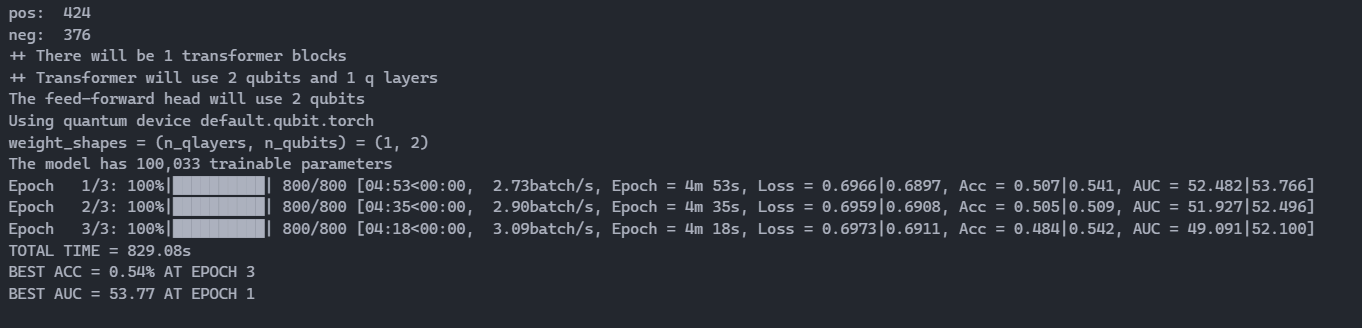


## Evaluation


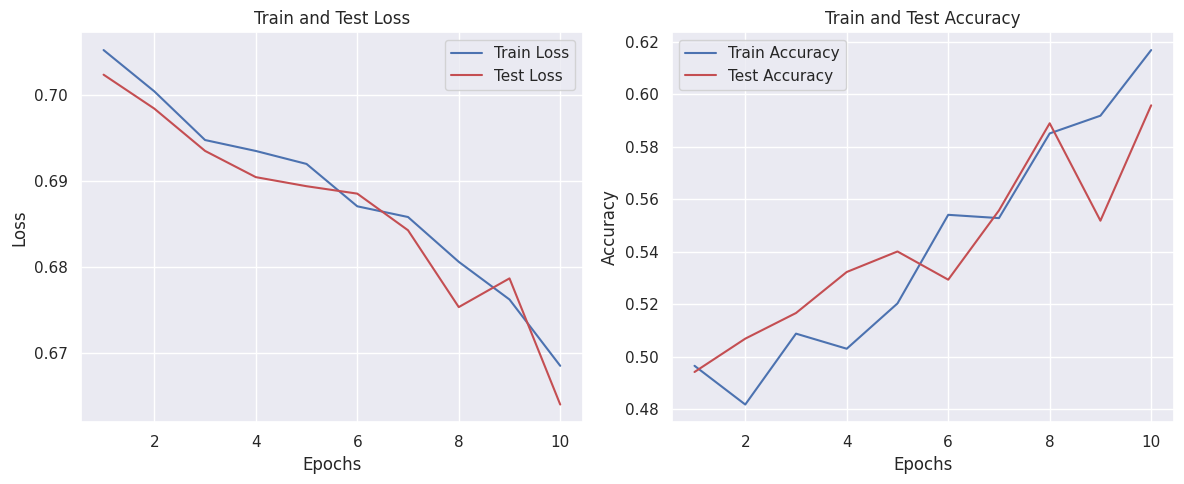

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

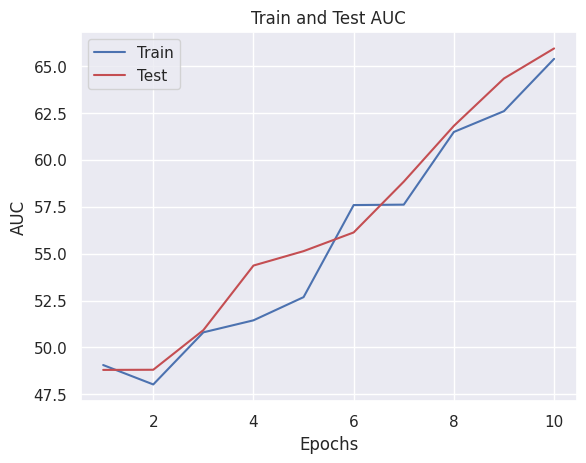

In [24]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [25]:
checkpoint = torch.load(
    ".models/model_and_metrics_epoch_10.pt"
)  # Replace x with the epoch number

# Load the metrics
epoch = checkpoint["epoch"]
train_loss = checkpoint["train_loss"]
train_acc = checkpoint["train_acc"]
train_auc = checkpoint["train_auc"]
test_loss = checkpoint["test_loss"]
test_acc = checkpoint["test_acc"]
test_auc = checkpoint["test_auc"]

test_acc

[0.494140625,
 0.5068359375,
 0.5166015625,
 0.5322265625,
 0.5400390625,
 0.529296875,
 0.5556640625,
 0.5888671875,
 0.5517578125,
 0.595703125]

In [26]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(auc, label="Quantum Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)